<a href="https://colab.research.google.com/github/saruj26/Finance_Research/blob/main/Financial_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

file_path = "/content/drive/MyDrive/SP500_Project/Large_Data/all-the-news-2-1/all-the-news-2-1.csv"

# Read only required columns to reduce memory load
cols = ['date', 'author', 'title', 'article', 'publication']

df = pd.read_csv(file_path, usecols=cols)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter only Reuters news
reuters_df = df[df['publication'] == 'Reuters']

# Sort by date (oldest → newest)
reuters_df = reuters_df.sort_values(by='date', ascending=True)

# If you want newest → oldest instead, use:
# reuters_df = reuters_df.sort_values(by='date', ascending=False)

# Save to new CSV file
output_path = "/content/drive/MyDrive/SP500_Index/financial_News.csv"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

reuters_df.to_csv(output_path, index=False)

print("✅ File created successfully!")
print("Total Reuters articles:", len(reuters_df))
print("Saved at:", output_path)

In [ ]:
import pandas as pd
import os

# --------------------------------------------------
# Project base path
# --------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

# Input: Reuters-only dataset
input_path = os.path.join(PROJECT_PATH, "financial_News.csv")

# Output: SP500-related Reuters news (inside data folder)
output_path = os.path.join(PROJECT_PATH, "Data", "sp500_financial_news.csv")

# Create data folder if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --------------------------------------------------
# SP500-impact keywords
# --------------------------------------------------
sp500_keywords = (
    r"stock|stocks|equity|equities|share|shares|index|indices|"
    r"market|markets|wall street|dow|nasdaq|s&p|sp500|"
    r"economy|economic|gdp|growth|recession|slowdown|"
    r"fed|federal reserve|interest rate|rates|rate hike|rate cut|"
    r"inflation|deflation|cpi|ppi|unemployment|jobs|payroll|"
    r"bank|banks|banking|financial|finance|credit|debt|"
    r"earnings|revenue|profit|loss|guidance|forecast|"
    r"company|corporate|business|firm|ceo|cfo|"
    r"policy|government|senate|congress|white house|"
    r"trade|tariff|sanction|export|import|"
    r"oil|crude|energy|gold|commodity|commodities|"
    r"crisis|volatility|election|budget|shutdown|debt ceiling|"
    r"trump|biden"
)

# --------------------------------------------------
# Load Reuters dataset (FAST)
# --------------------------------------------------
df = pd.read_csv(input_path)

# Ensure date format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Remove empty articles
df = df.dropna(subset=['article'])
df = df[df['article'].str.strip() != ""]

# --------------------------------------------------
# Apply SP500 keyword filter
# --------------------------------------------------
financial_df = df[
    df['article'].str.contains(
        sp500_keywords,
        case=False,
        regex=True,
        na=False
    )
]

# Sort by date
financial_df = financial_df.sort_values(by='date')

# --------------------------------------------------
# Save filtered dataset
# --------------------------------------------------
os.makedirs(os.path.dirname(output_path), exist_ok=True)
financial_df.to_csv(output_path, index=False)

# --------------------------------------------------
# Summary
# --------------------------------------------------
print("✅ SP500-related Reuters dataset created")
print("Total Reuters articles (input):", len(df))
print("Total SP500-related articles:", len(financial_df))
print("Saved at:", output_path)


/tmp/ipython-input-3675117897.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ SP500-related Reuters dataset created
Total Reuters articles (input): 825134
Total SP500-related articles: 774042
Saved at: /content/drive/MyDrive/SP500_Index/Data/sp500_financial_news.csv


In [ ]:
import pandas as pd
import os
import re

# --------------------------------------------------
# Paths
# --------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
input_path  = os.path.join(PROJECT_PATH, "Data", "sp500_financial_news.csv")
output_path = os.path.join(PROJECT_PATH, "Data", "financial_News.csv")

os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --------------------------------------------------
# Load dataset
# --------------------------------------------------
df = pd.read_csv(input_path)

# Save original columns (final CSV will ONLY contain these)
original_cols = df.columns.tolist()

# --------------------------------------------------
# Preprocess
# --------------------------------------------------
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

# day column only for grouping (not saved)
df["day"] = df["date"].dt.date

# clean text
df["title"] = df["title"].fillna("").astype(str)
df["article"] = df["article"].fillna("").astype(str)

# remove empty titles or articles (optional but good)
df = df[df["title"].str.strip() != ""]
df = df[df["article"].str.strip() != ""]

# --------------------------------------------------
# Keyword scoring
# --------------------------------------------------
sp500_keywords = (
    r"stock|stocks|equity|equities|share|shares|index|indices|"
    r"market|markets|wall street|dow|nasdaq|s&p|sp500|"
    r"economy|economic|gdp|growth|recession|slowdown|"
    r"fed|federal reserve|interest rate|rates|rate hike|rate cut|"
    r"inflation|deflation|cpi|ppi|unemployment|jobs|payroll|"
    r"bank|banks|banking|financial|finance|credit|debt|"
    r"earnings|revenue|profit|loss|guidance|forecast|"
    r"company|corporate|business|firm|ceo|cfo|"
    r"policy|government|senate|congress|white house|"
    r"trade|tariff|sanction|export|import|"
    r"oil|crude|energy|gold|commodity|commodities|"
    r"crisis|volatility|election|budget|shutdown|debt ceiling|"
    r"trump|biden"
)

impact_keywords = (
    r"rate hike|rate cut|interest rate|federal reserve|fed|"
    r"cpi|ppi|inflation|unemployment|payroll|jobs report|"
    r"recession|crisis|default|bank run|credit crunch|"
    r"earnings|profit warning|guidance cut|downgrade|"
    r"selloff|plunge|crash|rally|surge|volatility|"
    r"sanctions|war|geopolitical|tariff|trade deal|shutdown|debt ceiling"
)

pattern_sp500  = re.compile(sp500_keywords, flags=re.IGNORECASE)
pattern_impact = re.compile(impact_keywords, flags=re.IGNORECASE)

# internal score columns (not saved)
df["_kw_count"] = df["article"].apply(lambda x: len(pattern_sp500.findall(x)))
df["_impact_count"] = df["article"].apply(lambda x: len(pattern_impact.findall(x)))
df["_score"] = (df["_kw_count"] * 1.0) + (df["_impact_count"] * 3.0)

# title contributes more
df["_title_kw"] = df["title"].apply(lambda x: len(pattern_sp500.findall(x)))
df["_title_impact"] = df["title"].apply(lambda x: len(pattern_impact.findall(x)))
df["_score"] += (df["_title_kw"] * 2.0) + (df["_title_impact"] * 4.0)

# --------------------------------------------------
# ✅ REMOVE DUPLICATES (IMPORTANT)
# --------------------------------------------------
# 1) Remove exact duplicate articles (same article text)
df = df.drop_duplicates(subset=["article"], keep="first")

# 2) Remove duplicate titles within the same day (Reuters update problem)
# Keep the highest score version
df = df.sort_values(["day", "_score"], ascending=[True, False])
df = df.drop_duplicates(subset=["day", "title"], keep="first")

# --------------------------------------------------
# Top 10 per day
# --------------------------------------------------
df = df.sort_values(["day", "_score"], ascending=[True, False])
top10_daywise = df.groupby("day", group_keys=False).head(10)

# --------------------------------------------------
# Save ONLY original columns
# --------------------------------------------------
top10_daywise = top10_daywise[original_cols]
top10_daywise.to_csv(output_path, index=False)

print("✅ Day-wise Top-10 SP500 impact news created (NO duplicates)")
print("Saved at:", output_path)
print("Total rows in output:", len(top10_daywise))


/tmp/ipython-input-591620375.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ Day-wise Top-10 SP500 impact news created (NO duplicates)
Saved at: /content/drive/MyDrive/SP500_Index/Data/financial_News.csv
Total rows in output: 15429


In [ ]:
import pandas as pd

# Load data
file_path = "/content/drive/MyDrive/SP500_Index/Data/financial_News.csv"
df = pd.read_csv(file_path)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates (if any)
df = df.dropna(subset=['date'])

# Get full date range (calendar days)
start_date = df['date'].min()
end_date = df['date'].max()

full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Find missing dates
existing_dates = pd.to_datetime(df['date'].unique())
missing_dates = full_range.difference(existing_dates)

# Format missing dates as dd.mm.yyyy
missing_dates_formatted = missing_dates.strftime('%d.%m.%Y')

# Results
missing_days_count = len(missing_dates_formatted)

print(f"Total missing days: {missing_days_count}")
print("Missing days:")
print(missing_dates_formatted.tolist())


Total missing days: 5
Missing days:
['29.07.2019', '30.07.2019', '31.07.2019', '03.08.2019', '29.03.2020']


In [ ]:
import pandas as pd
import os

# --------------------------------------------------
# Dataset path
# --------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
input_path = os.path.join(PROJECT_PATH, "Data", "financial_News.csv")

# --------------------------------------------------
# Load dataset
# --------------------------------------------------
df = pd.read_csv(input_path)

print("Total rows in dataset:", len(df))

# --------------------------------------------------
# 1️⃣ Total duplicate title rows count
# --------------------------------------------------
duplicate_rows_count = df.duplicated(subset=["title"]).sum()
print("Duplicate title rows count:", duplicate_rows_count)

# --------------------------------------------------
# 2️⃣ All rows that have duplicate titles
# --------------------------------------------------
duplicate_title_rows = df[df.duplicated(subset=["title"], keep=False)]

print("Total rows with duplicate titles (including originals):", len(duplicate_title_rows))

# Show sample
duplicate_title_rows[["date", "title"]].head(10)


Total rows in dataset: 15425
Duplicate title rows count: 131
Total rows with duplicate titles (including originals): 209


date                                              title
73     1/8/2016  Fitch Affirms Luxembourg at 'AAA'; Outlook Stable
141   1/15/2016    Fitch Affirms Iceland at 'BBB+'; Outlook Stable
144   1/15/2016  Fitch Affirms Autonomous Community of Madrid a...
317    2/1/2016      European Factors to Watch-Equity futures rise
692   3/10/2016                        DALCOMP NEGOTIATED CALENDAR
763   3/17/2016      European Factors to Watch-Equity futures rise
819   3/22/2016       German stocks - Factors to watch on March 22
960    4/6/2016     Factbox: Fed staff forecasts from FOMC minutes
990    4/9/2016  Puerto Rico governor declares emergency at Gov...
1017  4/11/2016  Puerto Rico governor declares emergency at Gov...

# Preprocessing Financial News Dataset

This notebook cleans the financial news dataset for:
- FinBERT sentiment analysis (headline)
- BERTopic topic modeling (article text with stopwords removed)

Outputs:
- preprocessed_financial_news.csv
- financial_news_daily.csv


In [ ]:
# ========================================================
# Preprocessing Financial News Dataset for FinBERT & BERTopic
# ========================================================

# Step 1: Import Required Libraries
# ========================================================
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords


# Step 2: Dataset Path Configuration
# ========================================================
PROJECT_PATH = '/content/drive/MyDrive/SP500_Index'
INPUT_DATASET_PATH = os.path.join(PROJECT_PATH, 'Data/financial_News.csv')
OUTPUT_DIR_PATH = os.path.join(PROJECT_PATH, 'preprocessed_data')

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

# Step 3: Load Original Dataset
# ========================================================
print("Loading dataset...")
df = pd.read_csv(INPUT_DATASET_PATH)
print(f"Original dataset shape: {df.shape}")
print("\nFirst 5 rows of original dataset:")
print(df.head())

# Step 4: Handle Missing Values
# ========================================================
print("\nHandling missing values...")

df = df.dropna(subset=['article'])
print(f"After dropping rows with missing articles: {df.shape}")

df['title'] = df['title'].fillna('')

df = df.dropna(subset=['date'])
print(f"After dropping rows with missing dates: {df.shape}")

if 'publication' in df.columns:
    df = df.drop(columns=['publication'])
    print("Publication column removed")

# Step 5: Standardize Date Format
# ========================================================
print("\nStandardizing date format...")

# ✅ FIX: Your dates are like 1/1/2016, so parse using explicit format
# This will correctly read M/D/YYYY or MM/DD/YYYY
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')

# If some rows are like '1/1/2016' (single digit), the above still works.
# Drop rows that failed parsing
df = df.dropna(subset=['date'])

# Force final format (YYYY-MM-DD)
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

print("Date format standardized to YYYY-MM-DD")

# Step 6: Text Cleaning Function
# ========================================================
def clean_text(text):
    text = str(text)
    text = re.sub(r'\n|\r', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s\.]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Step 7: Clean Title and Article Columns
# ========================================================
print("\nCleaning text data...")
df['cleaned_title'] = df['title'].apply(clean_text)
df['cleaned_article'] = df['article'].apply(clean_text)
print("Title and article columns cleaned")

# Step 8: Stopwords Removal (Optional)
# ========================================================
print("\nSetting up stopwords removal...")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['cleaned_article'] = df['cleaned_article'].apply(remove_stopwords)
print("Stopwords removed from articles")

# Step 9: Create Combined Text Field
# ========================================================
print("\nCreating combined text field...")
df['cleaned_text'] = df['cleaned_title'] + '. ' + df['cleaned_article']
print("Combined text field created for FinBERT & BERTopic analysis")

# Step 10: Sort by Date
# ========================================================
print("\nSorting data by date...")
df = df.sort_values('date')
print(f"Data sorted by date. Date range: {df['date'].min()} to {df['date'].max()}")

# Step 11: Save Preprocessed Dataset
# ========================================================
print("\nSaving preprocessed datasets...")

ARTICLE_LEVEL_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH, 'preprocessed_financial_news.csv')
df.to_csv(ARTICLE_LEVEL_OUTPUT_PATH, index=False)
print(f"Article-level preprocessed data saved to: {ARTICLE_LEVEL_OUTPUT_PATH}")

# Step 12: Create Daily Aggregated Dataset
# ========================================================
print("\nCreating daily aggregated dataset...")
daily_df = df.groupby('date')['cleaned_text'].apply(lambda x: ' '.join(x)).reset_index()

DAILY_AGGREGATED_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH, 'financial_news_daily.csv')
daily_df.to_csv(DAILY_AGGREGATED_OUTPUT_PATH, index=False)
print(f"Daily aggregated data saved to: {DAILY_AGGREGATED_OUTPUT_PATH}")

# Step 13: Summary Statistics
# ========================================================
print("\n" + "="*50)
print("PREPROCESSING COMPLETE - SUMMARY STATISTICS")
print("="*50)
print(f"Total articles processed: {len(df)}")
print(f"Total unique dates: {df['date'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Average article length (characters): {df['cleaned_text'].str.len().mean():.0f}")
print(f"Output files saved in: {OUTPUT_DIR_PATH}")
print("="*50)

print("\nSample of processed data (first 3 rows):")
print(df[['date', 'cleaned_title', 'cleaned_article']].head(3))


Loading dataset...
Original dataset shape: (15425, 5)

First 5 rows of original dataset:
       date             author  \
0  1/1/2016  Chuck Mikolajczak   
1  1/1/2016      Lisa Rapaport   
2  1/1/2016                NaN   
3  1/1/2016                NaN   
4  1/1/2016     Diana Crandall   

                                               title  \
0  Investors look to January effect at start of 2...   
1  More patients may be able to safely shower aft...   
2  Brazil's Rousseff signs budget law, vetoes con...   
3  Russia says Ukraine defaulted on $3 billion Eu...   
4  Skywriters target Trump in aerial Rose Parade ...   

                                             article publication  
0  NEW YORK (Reuters) - As Wall Street wraps up i...     Reuters  
1  (Reuters Health) - Many patients may be able t...     Reuters  
2  SAO PAULO/RIO DE JANEIRO, Jan 1 (Reuters) - Br...     Reuters  
3  MOSCOW (Reuters) - Russia will file a lawsuit ...     Reuters  
4  PASADENA, Calif. (Reuters) - Fi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stopwords removed from articles

Creating combined text field...
Combined text field created for FinBERT & BERTopic analysis

Sorting data by date...
Data sorted by date. Date range: 2016-01-01 to 2020-03-30

Saving preprocessed datasets...
Article-level preprocessed data saved to: /content/drive/MyDrive/SP500_Index/preprocessed_data/preprocessed_financial_news.csv

Creating daily aggregated dataset...
Daily aggregated data saved to: /content/drive/MyDrive/SP500_Index/preprocessed_data/financial_news_daily.csv

PREPROCESSING COMPLETE - SUMMARY STATISTICS
Total articles processed: 15425
Total unique dates: 1546
Date range: 2016-01-01 to 2020-03-30
Average article length (characters): 3640
Output files saved in: /content/drive/MyDrive/SP500_Index/preprocessed_data

Sample of processed data (first 3 rows):
         date                                      cleaned_title  \
0  2016-01-01  investors look to january effect at start of 2016   
1  2016-01-01  more patients may be able to safel

# S&P 500 Data Collection using YahooFinancials


The downloaded data will be used for:
- Financial time-series analysis
- Market trend visualization
- Correlation with financial news sentiment

Library Required:
- yahoofinancials


In [ ]:
!pip install yahoofinancials


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38618 sha256=d87715d5563e45cbe9119c0eddc7e086958680c3dbf7dd3f68f1cc55a478aa7d
  Stored in directory: /root/.cache/pip/wheels/b0/e1/ca/e683b02e57db550881c8ebb89ba3eccb7a5c0ebfad7f03acea
Successfully built yahoofinancials


[*********************100%***********************]  1 of 1 completed

✅ Successfully retrieved S&P 500 data from 2016-01-01 to 2022-12-31.
✅ Saved CSV to: /content/drive/MyDrive/SP500_Index/Data/sp500_index.csv


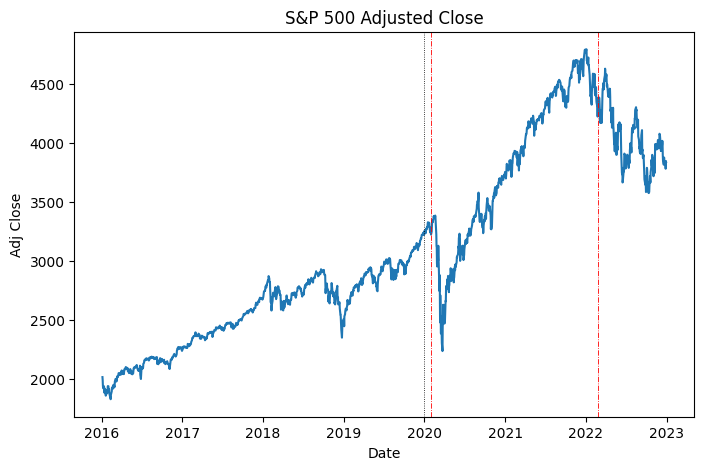

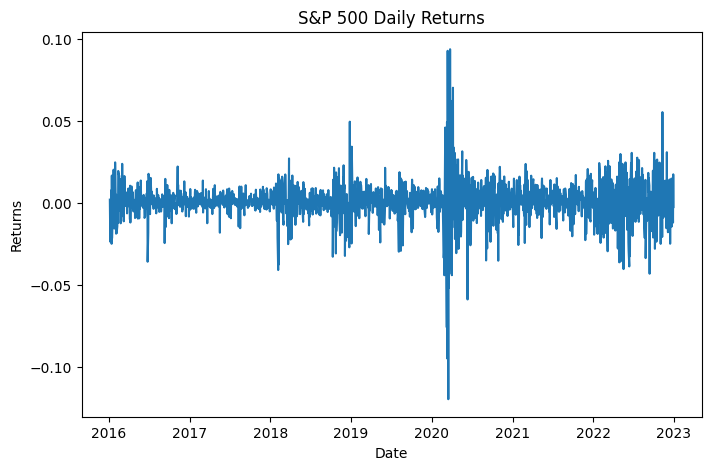

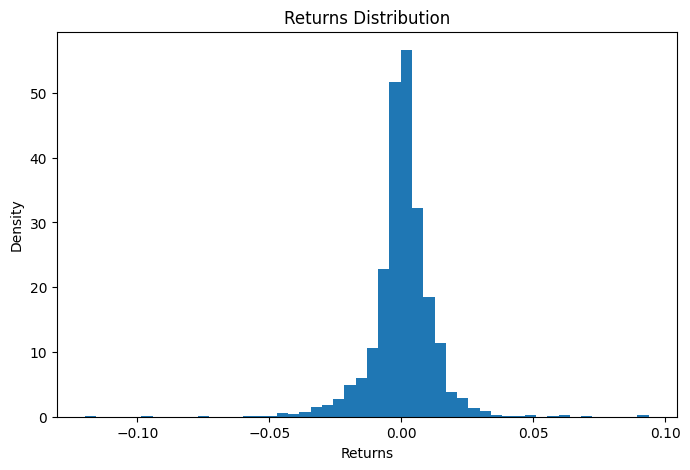

                            OLS Regression Results                            
Dep. Variable:               adjclose   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.613e+05
Date:                Sat, 17 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:16:34   Log-Likelihood:                -8932.8
No. Observations:                1761   AIC:                         1.787e+04
Df Residuals:                    1758   BIC:                         1.789e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.5161      6.160      2.681

In [ ]:
# -*- coding: utf-8 -*-
"""
S&P 500 (^GSPC) Download + Preprocessing + Save + Plots + OLS
Fixed for Google Colab + Google Drive
"""

# -------------------------
# Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yfinance as yf

# -------------------------
# Google Drive Base Path
# -------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
DATA_DIR = os.path.join(PROJECT_PATH, "Data")
os.makedirs(DATA_DIR, exist_ok=True)

# -------------------------
# Download Stock Price
# -------------------------
ticker = "^GSPC"
start_date = "2016-01-01"
end_date = "2022-12-31"

# IMPORTANT: auto_adjust=False -> ensures "Adj Close" exists
gspc_prices = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

print(f"✅ Successfully retrieved S&P 500 data from {start_date} to {end_date}.")

# -------------------------
# Preprocessing
# -------------------------
gspc_prices = gspc_prices.reset_index()  # Date becomes a column
gspc_prices["formatted_date"] = pd.to_datetime(gspc_prices["Date"])

# create adjclose column (matches your old code style)
gspc_prices["adjclose"] = gspc_prices["Adj Close"]

# sort by date
gspc_prices = gspc_prices.sort_values("formatted_date").reset_index(drop=True)

# time trend
gspc_prices["time_trend"] = np.arange(len(gspc_prices))

# lag + returns
gspc_prices["adjclose_lag1"] = gspc_prices["adjclose"].shift(1)
gspc_prices["returns"] = (gspc_prices["adjclose"] - gspc_prices["adjclose_lag1"]) / gspc_prices["adjclose_lag1"]

# drop NA from lag
gspc_prices = gspc_prices.dropna().reset_index(drop=True)

# -------------------------
# Save CSV
# -------------------------
output_file = os.path.join(DATA_DIR, "sp500_index.csv")
gspc_prices.to_csv(output_file, index=False)
print(f"✅ Saved CSV to: {output_file}")

# -------------------------
# Visualization
# -------------------------
dates_list = gspc_prices["formatted_date"]
adjclose_list = gspc_prices["adjclose"]
returns_list = gspc_prices["returns"]

plt.figure(figsize=(8, 5))
plt.plot(dates_list, adjclose_list)
plt.axvline(dt.datetime(2019, 12, 31), color="black", linewidth=0.6, ls=":")
plt.axvline(dt.datetime(2020, 1, 30), color="red", linewidth=0.6, ls="-.")
plt.axvline(dt.datetime(2022, 2, 24), color="red", linewidth=0.6, ls="-.")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.title("S&P 500 Adjusted Close")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(dates_list, returns_list)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("S&P 500 Daily Returns")
plt.show()

# Histogram of returns
plt.figure(figsize=(8, 5))
plt.hist(gspc_prices["returns"], bins=50, density=True)
plt.xlabel("Returns")
plt.ylabel("Density")
plt.title("Returns Distribution")
plt.show()

# -------------------------
# OLS Regression
# -------------------------
# Formula method
model = smf.ols("adjclose ~ time_trend + adjclose_lag1", data=gspc_prices).fit()
print(model.summary())

# Numpy method (same result style)
X = gspc_prices[["time_trend", "adjclose_lag1"]].to_numpy()
X = sm.add_constant(X)
y = gspc_prices["adjclose"].to_numpy()

model2 = sm.OLS(y, X).fit()
print(model2.summary())


# Preprocessing S&P 500 Index Data

This section preprocesses the raw S&P 500 index dataset for
time-series analysis and integration with financial news sentiment data.

Steps performed:
- Load raw S&P 500 index data
- Select relevant columns (Date and Adjusted Close)
- Handle missing and duplicate values
- Sort data chronologically
- Save the cleaned dataset for downstream analysis

The output dataset will be used for:
- Market trend analysis
- Correlation with daily financial news sentiment
- Predictive modeling tasks


In [25]:
import pandas as pd
import os

# --------------------------------------------------------
# Project Path Definition
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

RAW_DATA_PATH = os.path.join(PROJECT_PATH, "Data", "sp500_index.csv")
SAVE_PATH = os.path.join(PROJECT_PATH, "preprocessed_data")

os.makedirs(SAVE_PATH, exist_ok=True)

# --------------------------------------------------------
# Load Raw S&P 500 Index Data
# --------------------------------------------------------
df = pd.read_csv(RAW_DATA_PATH)

# --------------------------------------------------------
# Select Required Columns
# --------------------------------------------------------
df_clean = df[['Date', 'Adj Close']].copy()

# ✅ Rename columns (Date → date, Adj Close → index)
df_clean.rename(columns={'Date': 'date', 'Adj Close': 'index'}, inplace=True)

# --------------------------------------------------------
# Date Handling
# --------------------------------------------------------
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')
df_clean.dropna(subset=['date'], inplace=True)

# --------------------------------------------------------
# Sort Chronologically
# --------------------------------------------------------
df_clean.sort_values('date', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# --------------------------------------------------------
# Handle Missing Values
# --------------------------------------------------------
df_clean['index'] = df_clean['index'].ffill()
df_clean['index'] = df_clean['index'].bfill()

# --------------------------------------------------------
# Remove Duplicate Dates
# --------------------------------------------------------
df_clean.drop_duplicates(subset=['date'], keep='first', inplace=True)

# --------------------------------------------------------
# Save Cleaned Dataset
# --------------------------------------------------------
cleaned_path = os.path.join(
    SAVE_PATH,
    "preprocessed_sp500_index.csv"
)

df_clean.to_csv(cleaned_path, index=False)

# --------------------------------------------------------
# Verification Output
# --------------------------------------------------------
print("✓ Cleaned dataset saved to:", cleaned_path)
print("\nFirst 5 rows:")
print(df_clean.head())

print("\nLast 5 rows:")
print(df_clean.tail())


✓ Cleaned dataset saved to: /content/drive/MyDrive/SP500_Index/preprocessed_data/preprocessed_sp500_index.csv

First 5 rows:
        date               index
0 2016-01-05     2016.7099609375
1 2016-01-06   1990.260009765625
2 2016-01-07  1943.0899658203125
3 2016-01-08   1922.030029296875
4 2016-01-11  1923.6700439453125

Last 5 rows:
           date              index
1756 2022-12-23  3844.820068359375
1757 2022-12-27            3829.25
1758 2022-12-28  3783.219970703125
1759 2022-12-29  3849.280029296875
1760 2022-12-30             3839.5


# FinBERT Sentiment Analysis on Preprocessed Financial News Headlines

This section performs sentiment analysis on the cleaned news headlines using
FinBERT (ProsusAI/finbert).

Input:
- preprocessed_data/preprocessed_financial_news.csv

Process:
- Load the FinBERT tokenizer and model
- Predict sentiment probabilities (negative, neutral, positive) for each headline
- Compute a financial sentiment score: (positive_probability - negative_probability)
- Save the output for later merging with S&P 500 data

Output:
- sentiment_results/financial_news_finbert_title_sentiment.csv


In [ ]:
# ========================================================
# FinBERT Sentiment Analysis on Preprocessed Financial News Titles
# ========================================================

# Step 0: Install Dependencies (Run only once if not installed)
# !pip install -q transformers torch

# Step 1: Import Libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import os

# Step 2: Project Path Definition
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "sentiment_results")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Input file (as you requested)
INPUT_FILE = os.path.join(INPUT_DIR, "preprocessed_financial_news.csv")

# Output file
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "finbert_title_sentiment.csv")

# Step 3: Load Preprocessed Dataset
df = pd.read_csv(INPUT_FILE)
print("✓ Loaded dataset:", df.shape)

# Step 4: Load FinBERT Model
FINBERT_MODEL = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL)
model.eval()

# Step 5: Function to compute FinBERT sentiment
labels = ["negative", "neutral", "positive"]

def get_finbert_sentiment(text):
    # Return 5 values always (to avoid errors)
    if not isinstance(text, str) or text.strip() == "":
        return None, None, None, None, None

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    sentiment = labels[int(np.argmax(probs))]

    # Financial sentiment score = positive - negative
    sentiment_score = float(probs[2] - probs[0])

    return sentiment, float(probs[0]), float(probs[1]), float(probs[2]), sentiment_score

# Step 6: Apply FinBERT to title column
# (If your file uses 'title' instead of 'cleaned_title', use df['title'])
results = df["title"].apply(get_finbert_sentiment)

df["sentiment_label"] = results.apply(lambda x: x[0])
df["neg_prob"] = results.apply(lambda x: x[1])
df["neu_prob"] = results.apply(lambda x: x[2])
df["pos_prob"] = results.apply(lambda x: x[3])
df["sentiment_score"] = results.apply(lambda x: x[4])

# Step 7: Select required output columns (minimal)
finbert_output = df[["date", "title", "sentiment_score"]].copy()

# Step 8: Save Output
finbert_output.to_csv(OUTPUT_FILE, index=False)

print("✓ FinBERT sentiment saved to:", OUTPUT_FILE)
print(finbert_output.head())


✓ Loaded dataset: (15425, 7)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✓ FinBERT sentiment saved to: /content/drive/MyDrive/SP500_Index/sentiment_results/finbert_title_sentiment.csv
         date                                              title  \
0  2016-01-01  Investors look to January effect at start of 2...   
1  2016-01-01  More patients may be able to safely shower aft...   
2  2016-01-01  Brazil's Rousseff signs budget law, vetoes con...   
3  2016-01-01  Russia says Ukraine defaulted on $3 billion Eu...   
4  2016-01-01  Skywriters target Trump in aerial Rose Parade ...   

   sentiment_score  
0         0.880349  
1        -0.523059  
2         0.173503  
3        -0.001233  
4         0.728562  


In [21]:
# ========================================================
# FinBERT Sentiment Day-by-Day Aggregation
# ========================================================

import pandas as pd
import os

# -----------------------------
# Project Paths
# -----------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_DIR = os.path.join(PROJECT_PATH, "sentiment_results")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "sentiment_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Input file (FinBERT article-level sentiment)
INPUT_FILE = os.path.join(INPUT_DIR, "finbert_title_sentiment.csv")

# Output file (day-by-day aggregated)
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "finbert_daily_sentiment.csv")

# -----------------------------
# Load FinBERT output
# -----------------------------
df = pd.read_csv(INPUT_FILE)
print("✓ Loaded article-level sentiment:", df.shape)

# -----------------------------
# Ensure 'date' is datetime type
# -----------------------------
df['date'] = pd.to_datetime(df['date'])

# -----------------------------
# Day-by-day aggregation
# -----------------------------
# Average sentiment_score per day
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()


# -----------------------------
# Save aggregated results
# -----------------------------
daily_sentiment.to_csv(OUTPUT_FILE, index=False)
print("✓ Daily aggregated FinBERT sentiment saved to:", OUTPUT_FILE)
print(daily_sentiment.head())

✓ Loaded article-level sentiment: (15425, 3)
✓ Daily aggregated FinBERT sentiment saved to: /content/drive/MyDrive/SP500_Index/sentiment_results/finbert_daily_sentiment.csv
        date  sentiment_score
0 2016-01-01         0.183716
1 2016-01-02         0.059635
2 2016-01-03         0.153999
3 2016-01-04         0.193581
4 2016-01-05         0.240512


# Topic Modeling using LDA

- Applies Latent Dirichlet Allocation (LDA) on cleaned financial news articles  
- Uses bag-of-words representation with CountVectorizer  
- Identifies latent topics based on word co-occurrence patterns  
- Assigns a dominant topic and probability to each article  
- Topic results are saved for comparative analysis with BERTopic and sentiment data  
- pyLDAvis is used for interactive topic visualization and interpretation


In [ ]:
!pip install gensim pyLDAvis scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 94.1 MB/s eta 0:00:00


In [ ]:
# ========================================================
# LDA Topic Modeling on Cleaned Financial News Articles
# ========================================================

# Step 0: Install Required Libraries (run once)
# !pip install -q gensim pyLDAvis scikit-learn

# Step 1: Import Libraries
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# --------------------------------------------------------
# Project Path Definition
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Load Cleaned Dataset
# --------------------------------------------------------
input_file = os.path.join(INPUT_DIR, "preprocessed_financial_news.csv")
df = pd.read_csv(input_file)

# --------------------------------------------------------
# Step 2: Filter Relevant Financial & Political Articles
# --------------------------------------------------------
df = df[df['cleaned_article'].str.contains(
    r"stock|market|fed|economy|finance|earnings|bank|politics|government|trump|biden|senate",
    case=False,
    regex=True
)]

# Reset index
df = df.reset_index(drop=True)

# --------------------------------------------------------
# Step 2a: Remove common reporting words
# --------------------------------------------------------
df['cleaned_article'] = df['cleaned_article'].str.replace(
    r'\b(said|reuters|according|news)\b', '', regex=True
)

# --------------------------------------------------------
# Step 3: Prepare Documents
# --------------------------------------------------------
documents = df["cleaned_article"].astype(str).tolist()

# --------------------------------------------------------
# Step 4: Tokenization & Vectorization
# --------------------------------------------------------
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.9
)
X = vectorizer.fit_transform(documents)

# Convert to gensim corpus
corpus = [
    [word for word in doc.split() if word in vectorizer.vocabulary_]
    for doc in documents
]

# Create dictionary
dictionary = corpora.Dictionary(corpus)

# Create Bag-of-Words corpus
bow_corpus = [dictionary.doc2bow(text) for text in corpus]

# --------------------------------------------------------
# Step 5: Train LDA Model
# --------------------------------------------------------
num_topics = 10

lda_model = models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True
)

# --------------------------------------------------------
# Step 6: Display Topics
# --------------------------------------------------------
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}\n")

# --------------------------------------------------------
# Step 7: Assign Dominant Topic to Each Document
# --------------------------------------------------------
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    topic_probs_sorted = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs_sorted[0][0], topic_probs_sorted[0][1]

dominant_topics = [get_dominant_topic(bow) for bow in bow_corpus]
for i in range(num_topics):
    df[f"topic_{i}_prob"] = [dict(lda_model.get_document_topics(bow)).get(i, 0) for bow in bow_corpus]

# --------------------------------------------------------
# Step 8: Save LDA Results
# --------------------------------------------------------
lda_output_file = os.path.join(OUTPUT_DIR, "lda_output_filtered.csv")
df.to_csv(lda_output_file, index=False)
print("✓ LDA topic modeling results saved at:", lda_output_file)

# --------------------------------------------------------
# Step 9: Topic Visualization (Colab-safe)
# --------------------------------------------------------
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

# Option A: Display inside notebook (recommended)
pyLDAvis.enable_notebook()
display(lda_vis)

# Option B: Save as HTML
html_path = os.path.join(OUTPUT_DIR, "lda_vis_filtered.html")
pyLDAvis.save_html(lda_vis, html_path)
print("✓ LDAvis HTML saved at:", html_path)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

Topic 0: 0.033*"fitch" + 0.023*"ratings" + 0.023*"rating" + 0.011*"information" + 0.009*"reports" + 0.008*"issuer" + 0.007*"available" + 0.007*"credit" + 0.006*"financial" + 0.005*"particular"

Topic 1: 0.019*"fed" + 0.018*"rate" + 0.015*"growth" + 0.014*"inflation" + 0.012*"economy" + 0.012*"rates" + 0.011*"policy" + 0.010*"percent" + 0.010*"economic" + 0.009*"central"

Topic 2: 0.012*"banks" + 0.012*"bank" + 0.011*"market" + 0.009*"markets" + 0.009*"financial" + 0.008*"central" + 0.007*"global" + 0.007*"investors" + 0.006*"rates" + 0.005*"economic"

Topic 3: 0.017*"trump" + 0.010*"president" + 0.006*"government" + 0.006*"united" + 0.005*"states" + 0.005*"house" + 0.005*"trumps" + 0.005*"washington" + 0.005*"told" + 0.004*"state"

Topic 4: 0.020*"results" + 0.019*"gmt" + 0.018*"conference" + 0.016*"releases" + 0.014*"holds" + 0.014*"data" + 0.014*"italian" + 0.014*"board" + 0.013*"italy" + 0.012*"followed"

Topic 5: 0.015*"percent" + 0.014*"dollar" + 0.014*"index" + 0.012*"markets" + 

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

✓ LDA topic modeling results saved at: /content/drive/MyDrive/SP500_Index/topic_results/lda_output_filtered.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.040489 -0.170729       1        1  15.609746
0     -0.073667 -0.116341       2        1  13.757539
1      0.067809  0.095540       3        1  12.384135
7      0.008567 -0.140407       4        1  11.565001
2      0.065425  0.009828       5        1  11.319641
5      0.089688  0.220994       6        1  11.033433
6      0.081314  0.000383       7        1  10.127741
9      0.078268  0.180034       8        1   7.864803
8      0.052030 -0.160247       9        1   5.410254
4     -0.409923  0.080945      10        1   0.927707, topic_info=         Term          Freq         Total Category  logprob  loglift
4087    fitch  26829.000000  26829.000000  Default  30.0000  30.0000
5139  ratings  18801.000000  18801.000000  Default  29.0000  29.0000
2803   rating  18411.000000  18411.000000  Default  28.0000  28.0000
1435    trade  26548.000000  26548.000000  Default  27.0000  27.0000
140   percent  33225.000000  33225.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
212      bank    480.084349  21991.197428  Topic10  -4.7288   0.8558
1483     euro    396.045347   6270.242436  Topic10  -4.9212   1.9182
492     share    356.056646   3878.958895  Topic10  -5.0277   2.2920
411    annual    352.277009   4100.570346  Topic10  -5.0383   2.2257
3706     sale    326.161876   2416.803854  Topic10  -5.1154   2.6774

[835 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
15594     10  0.994679  0800
18499     10  0.992845  0830
18833     10  0.997652  0900
18432     10  0.982305  0930
3131       1  0.065822  1000
...      ...       ...   ...
947        1  0.037532  zone
947        2  0.002375  zone
947        5  0.624269  zone
947        6  0.319736  zone
947        9  0.016153  zone

[2658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 8, 3, 6, 7, 10, 9, 5])

✓ LDAvis HTML saved at: /content/drive/MyDrive/SP500_Index/topic_results/lda_vis_filtered.html


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# --------------------------------------------------------
# Create LDA Topic Summary with Top Keywords
# --------------------------------------------------------
num_top_words = 20  # number of top keywords per topic
topics_summary = []

for i in range(num_topics):
    # Get top words for the topic
    top_words = lda_model.show_topic(i, topn=num_top_words)
    keywords = [word for word, prob in top_words]
    topics_summary.append({
        "topic_id": i,
        "top_keywords": ", ".join(keywords)
    })

# Convert to DataFrame
topics_summary_df = pd.DataFrame(topics_summary)

# Save topic summary to CSV
topic_summary_file = os.path.join(OUTPUT_DIR, "lda_topic_summary.csv")
topics_summary_df.to_csv(topic_summary_file, index=False)
print("✓ LDA topic summary saved at:", topic_summary_file)

# Optional: Display the topic summary
display(topics_summary_df)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ LDA topic summary saved at: /content/drive/MyDrive/SP500_Index/topic_results/lda_topic_summary.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

topic_id                                       top_keywords
0         0  fitch, ratings, rating, information, reports, ...
1         1  fed, rate, growth, inflation, economy, rates, ...
2         2  banks, bank, market, markets, financial, centr...
3         3  trump, president, government, united, states, ...
4         4  results, gmt, conference, releases, holds, dat...
5         5  percent, dollar, index, markets, rose, fell, s...
6         6  trade, china, oil, tariffs, chinese, united, s...
7         7  company, billion, million, new, companies, bus...
8         8  new, tax, party, election, democratic, people,...
9         9  percent, sp, new, 500, earnings, nasdaq, point...

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [1]:
# ========================================================
# LDA Daily Aggregation + Topic Renaming
# ========================================================

import os
import pandas as pd

# --------------------------------------------------------
# Project Path (CHANGE ONLY THIS if needed)
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_DIR = os.path.join(PROJECT_PATH, "topic_results")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results/LDA")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Input: article-level LDA output with topic probabilities
# --------------------------------------------------------
input_file = os.path.join(INPUT_DIR, "lda_output_filtered.csv")
df = pd.read_csv(input_file)

# --------------------------------------------------------
# Ensure date format
# --------------------------------------------------------
# If your date is like '1/2/2016' or '2016-01-02', this handles both
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

# Use only date (remove time) for proper grouping
df["date"] = df["date"].dt.date

# --------------------------------------------------------
# Identify topic probability columns
# --------------------------------------------------------
topic_cols = [c for c in df.columns if c.startswith("topic_") and c.endswith("_prob")]
topic_cols = sorted(topic_cols, key=lambda x: int(x.split("_")[1]))  # topic_0_prob ... topic_9_prob

# --------------------------------------------------------
# Day-by-day aggregation (mean topic probabilities per date)
# --------------------------------------------------------
daily_df = df.groupby("date")[topic_cols].mean().reset_index()

# --------------------------------------------------------
# ✅ Rename topics based on your Excel top_keywords (topic_id → title)
# --------------------------------------------------------
# From your table:
# 0 = Fitch, ratings, credit, debt ...
# 1 = Fed, rate, inflation, economy ...
# 2 = Banks, markets, bonds, crisis ...
# 3 = Trump, US government, Iran, sanctions ...
# 4 = Italy, data, treasury, minister, meeting ...
# 5 = Dollar, index, stocks, oil, gold, yields, yen ...
# 6 = China, trade, tariffs, oil, imports/exports ...
# 7 = Company, business, firms, industry ...
# 8 = Election, tax, democrats, republicans, budget ...
# 9 = SP500, earnings, nasdaq, dow, market moves ...

topic_rename_map = {
    "topic_0_prob": "credit_ratings_risk",
    "topic_1_prob": "monetary_policy_inflation",
    "topic_2_prob": "banking_financial_markets",
    "topic_3_prob": "us_politics_geopolitics",
    "topic_4_prob": "economic_data_releases",
    "topic_5_prob": "stock_market_performance",
    "topic_6_prob": "trade_war_oil",
    "topic_7_prob": "corporate_business_activity",
    "topic_8_prob": "elections_fiscal_policy",
    "topic_9_prob": "index_earnings"
}

daily_df = daily_df.rename(columns=topic_rename_map)

# --------------------------------------------------------
# Save outputs
# --------------------------------------------------------
daily_output_file = os.path.join(OUTPUT_DIR, "lda_topic_10_daily_aggregated.csv")
daily_df.to_csv(daily_output_file, index=False)

print("✓ Saved:", daily_output_file)

# --------------------------------------------------------
# Optional: Save the mapping (for thesis / documentation)
# --------------------------------------------------------
mapping_df = pd.DataFrame(
    [{"topic_id": int(k.split("_")[1]), "old_col": k, "new_name": v}
     for k, v in topic_rename_map.items()]
).sort_values("topic_id")

mapping_file = os.path.join(OUTPUT_DIR, "lda_topic_10_rename.csv")
mapping_df.to_csv(mapping_file, index=False)
print("✓ Mapping saved:", mapping_file)

print("✓ Day-by-day aggregated LDA dataset columns renamed successfully.")
print("Columns now are:")
print(daily_df.columns.tolist())


✓ Saved: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_10_daily_aggregated.csv
✓ Mapping saved: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_10_rename.csv
✓ Day-by-day aggregated LDA dataset columns renamed successfully.
Columns now are:
['date', 'credit_ratings_risk', 'monetary_policy_inflation', 'banking_financial_markets', 'us_politics_geopolitics', 'economic_data_releases', 'stock_market_performance', 'trade_war_oil', 'corporate_business_activity', 'elections_fiscal_policy', 'index_earnings']


# LDA Model - Changing the topic size 12

In [ ]:
# ========================================================
# LDA Topic Modeling on Cleaned Financial News Articles
# ========================================================

# Step 0: Install Required Libraries (run once)
# !pip install -q gensim pyLDAvis scikit-learn

# Step 1: Import Libraries
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# --------------------------------------------------------
# Project Path Definition
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results/LDA")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Load Cleaned Dataset
# --------------------------------------------------------
input_file = os.path.join(INPUT_DIR, "preprocessed_financial_news.csv")
df = pd.read_csv(input_file)

# --------------------------------------------------------
# Step 2: Filter Relevant Financial & Political Articles
# --------------------------------------------------------
df = df[df['cleaned_article'].str.contains(
    r"stock|market|fed|economy|finance|earnings|bank|politics|government|trump|biden|senate",
    case=False,
    regex=True
)]

# Reset index
df = df.reset_index(drop=True)

# --------------------------------------------------------
# Step 2a: Remove common reporting words
# --------------------------------------------------------
df['cleaned_article'] = df['cleaned_article'].str.replace(
    r'\b(said|reuters|according|news)\b', '', regex=True
)

# --------------------------------------------------------
# Step 3: Prepare Documents
# --------------------------------------------------------
documents = df["cleaned_article"].astype(str).tolist()

# --------------------------------------------------------
# Step 4: Tokenization & Vectorization
# --------------------------------------------------------
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.9
)
X = vectorizer.fit_transform(documents)

# Convert to gensim corpus
corpus = [
    [word for word in doc.split() if word in vectorizer.vocabulary_]
    for doc in documents
]

# Create dictionary
dictionary = corpora.Dictionary(corpus)

# Create Bag-of-Words corpus
bow_corpus = [dictionary.doc2bow(text) for text in corpus]

# --------------------------------------------------------
# Step 5: Train LDA Model
# --------------------------------------------------------
num_topics = 12

lda_model = models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True
)

# --------------------------------------------------------
# Step 6: Display Topics
# --------------------------------------------------------
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}\n")

# --------------------------------------------------------
# Step 7: Assign Dominant Topic to Each Document
# --------------------------------------------------------
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    topic_probs_sorted = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs_sorted[0][0], topic_probs_sorted[0][1]

dominant_topics = [get_dominant_topic(bow) for bow in bow_corpus]
for i in range(num_topics):
    df[f"topic_{i}_prob"] = [dict(lda_model.get_document_topics(bow)).get(i, 0) for bow in bow_corpus]

# --------------------------------------------------------
# Step 8: Save LDA Results
# --------------------------------------------------------
lda_output_file = os.path.join(OUTPUT_DIR, "lda_topic_12_filtered.csv")
df.to_csv(lda_output_file, index=False)
print("✓ LDA topic modeling results saved at:", lda_output_file)

# --------------------------------------------------------
# Step 9: Topic Visualization (Colab-safe)
# --------------------------------------------------------
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

# Option A: Display inside notebook (recommended)
pyLDAvis.enable_notebook()
display(lda_vis)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

Topic 0: 0.033*"fitch" + 0.023*"ratings" + 0.023*"rating" + 0.011*"information" + 0.009*"reports" + 0.008*"issuer" + 0.007*"available" + 0.007*"credit" + 0.006*"financial" + 0.005*"particular"

Topic 1: 0.022*"growth" + 0.015*"percent" + 0.013*"economy" + 0.011*"inflation" + 0.011*"year" + 0.010*"rate" + 0.010*"economic" + 0.007*"data" + 0.007*"prices" + 0.006*"spending"

Topic 2: 0.015*"banks" + 0.015*"bank" + 0.010*"financial" + 0.009*"market" + 0.008*"coronavirus" + 0.008*"markets" + 0.007*"global" + 0.006*"european" + 0.006*"investors" + 0.006*"debt"

Topic 3: 0.018*"trump" + 0.010*"president" + 0.006*"house" + 0.006*"united" + 0.006*"states" + 0.006*"trumps" + 0.005*"washington" + 0.005*"government" + 0.005*"iran" + 0.005*"told"

Topic 4: 0.022*"results" + 0.020*"gmt" + 0.020*"conference" + 0.018*"releases" + 0.016*"holds" + 0.015*"data" + 0.015*"board" + 0.014*"italian" + 0.014*"followed" + 0.013*"italy"

Topic 5: 0.014*"dollar" + 0.014*"percent" + 0.013*"markets" + 0.013*"index"

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

✓ LDA topic modeling results saved at: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_12_filtered.csv


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replac

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.069107 -0.204364       1        1  14.035870
0      0.076771 -0.072659       2        1  13.690867
7     -0.025870 -0.170139       3        1  10.765052
5     -0.065269  0.216845       4        1  10.755144
2     -0.056322  0.005184       5        1   9.878902
1     -0.047590  0.130672       6        1   8.820938
6     -0.079712 -0.010696       7        1   8.698749
9     -0.028556  0.156425       8        1   7.488141
10    -0.086750  0.023813       9        1   6.850204
8     -0.062655 -0.180635      10        1   4.772799
11     0.028751  0.108017      11        1   3.399816
4      0.416308 -0.002464      12        1   0.843519, topic_info=          Term          Freq         Total Category  logprob  loglift
4087     fitch  26864.000000  26864.000000  Default  30.0000  30.0000
75         fed  15846.000000  15846.000000  Default  29.0000  29.0000
5139   ratings  18799.000000  18799.000000  Default  28.0000  28.0000
140    percent  33999.000000  33999.000000  Default  27.0000  27.0000
2803    rating  18380.000000  18380.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
212       bank    441.800193  22423.454941  Topic12  -4.7168   0.8483
3706      sale    327.776529   2422.660569  Topic12  -5.0153   2.7751
1483      euro    357.947161   6296.437468  Topic12  -4.9272   1.9080
411     annual    341.929534   4096.544991  Topic12  -4.9730   2.2920
342   european    320.098535   8542.412200  Topic12  -5.0390   1.4912

[989 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
17517     12  0.982418  0700
15594     12  0.996979  0800
18499     12  0.996766  0830
18833     12  0.997836  0900
18432     12  0.981041  0930
...      ...       ...   ...
947        4  0.292997  zone
947        5  0.654935  zone
947        6  0.001397  zone
947       10  0.014906  zone
23728      8  0.997468   zte

[3290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 6, 3, 2, 7, 10, 11, 9, 12, 5])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# --------------------------------------------------------
# Create LDA Topic Summary with Top Keywords
# --------------------------------------------------------
num_top_words = 20  # number of top keywords per topic
topics_summary = []

for i in range(num_topics):
    # Get top words for the topic
    top_words = lda_model.show_topic(i, topn=num_top_words)
    keywords = [word for word, prob in top_words]
    topics_summary.append({
        "topic_id": i,
        "top_keywords": ", ".join(keywords)
    })

# Convert to DataFrame
topics_summary_df = pd.DataFrame(topics_summary)

# Save topic summary to CSV
topic_summary_file = os.path.join(OUTPUT_DIR, "lda_topic_12_summary.csv")
topics_summary_df.to_csv(topic_summary_file, index=False)
print("✓ LDA topic summary saved at:", topic_summary_file)

# Optional: Display the topic summary
display(topics_summary_df)


✓ LDA topic summary saved at: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_12_summary.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

topic_id                                       top_keywords
0          0  fitch, ratings, rating, information, reports, ...
1          1  growth, percent, economy, inflation, year, rat...
2          2  banks, bank, financial, market, coronavirus, m...
3          3  trump, president, house, united, states, trump...
4          4  results, gmt, conference, releases, holds, dat...
5          5  dollar, percent, markets, index, rose, stocks,...
6          6  trade, china, tariffs, oil, chinese, united, s...
7          7  company, million, new, billion, business, comp...
8          8  new, party, election, tax, government, people,...
9          9  percent, sp, new, 500, earnings, nasdaq, share...
10        10  fed, rate, rates, policy, central, inflation, ...
11        11  saudi, percent, bank, hong, index, oil, centra...

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# LDA Model - Changing the topic size 8

In [ ]:
# ========================================================
# LDA Topic Modeling on Cleaned Financial News Articles
# ========================================================

# Step 0: Install Required Libraries (run once)
# !pip install -q gensim pyLDAvis scikit-learn

# Step 1: Import Libraries
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# --------------------------------------------------------
# Project Path Definition
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results/LDA")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Load Cleaned Dataset
# --------------------------------------------------------
input_file = os.path.join(INPUT_DIR, "preprocessed_financial_news.csv")
df = pd.read_csv(input_file)

# --------------------------------------------------------
# Step 2: Filter Relevant Financial & Political Articles
# --------------------------------------------------------
df = df[df['cleaned_article'].str.contains(
    r"stock|market|fed|economy|finance|earnings|bank|politics|government|trump|biden|senate",
    case=False,
    regex=True
)]

# Reset index
df = df.reset_index(drop=True)

# --------------------------------------------------------
# Step 2a: Remove common reporting words
# --------------------------------------------------------
df['cleaned_article'] = df['cleaned_article'].str.replace(
    r'\b(said|reuters|according|news)\b', '', regex=True
)

# --------------------------------------------------------
# Step 3: Prepare Documents
# --------------------------------------------------------
documents = df["cleaned_article"].astype(str).tolist()

# --------------------------------------------------------
# Step 4: Tokenization & Vectorization
# --------------------------------------------------------
vectorizer = CountVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.9
)
X = vectorizer.fit_transform(documents)

# Convert to gensim corpus
corpus = [
    [word for word in doc.split() if word in vectorizer.vocabulary_]
    for doc in documents
]

# Create dictionary
dictionary = corpora.Dictionary(corpus)

# Create Bag-of-Words corpus
bow_corpus = [dictionary.doc2bow(text) for text in corpus]

# --------------------------------------------------------
# Step 5: Train LDA Model
# --------------------------------------------------------
num_topics = 8

lda_model = models.LdaModel(
    corpus=bow_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True
)

# --------------------------------------------------------
# Step 6: Display Topics
# --------------------------------------------------------
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}\n")

# --------------------------------------------------------
# Step 7: Assign Dominant Topic to Each Document
# --------------------------------------------------------
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    topic_probs_sorted = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs_sorted[0][0], topic_probs_sorted[0][1]

dominant_topics = [get_dominant_topic(bow) for bow in bow_corpus]
for i in range(num_topics):
    df[f"topic_{i}_prob"] = [dict(lda_model.get_document_topics(bow)).get(i, 0) for bow in bow_corpus]

# --------------------------------------------------------
# Step 8: Save LDA Results
# --------------------------------------------------------
lda_output_file = os.path.join(OUTPUT_DIR, "lda_topic_08_filtered.csv")
df.to_csv(lda_output_file, index=False)
print("✓ LDA topic modeling results saved at:", lda_output_file)

# --------------------------------------------------------
# Step 9: Topic Visualization (Colab-safe)
# --------------------------------------------------------
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

# Option A: Display inside notebook (recommended)
pyLDAvis.enable_notebook()
display(lda_vis)


# --------------------------------------------------------
# Create LDA Topic Summary with Top Keywords
# --------------------------------------------------------
num_top_words = 20  # number of top keywords per topic
topics_summary = []

for i in range(num_topics):
    # Get top words for the topic
    top_words = lda_model.show_topic(i, topn=num_top_words)
    keywords = [word for word, prob in top_words]
    topics_summary.append({
        "topic_id": i,
        "top_keywords": ", ".join(keywords)
    })

# Convert to DataFrame
topics_summary_df = pd.DataFrame(topics_summary)

# Save topic summary to CSV
topic_summary_file = os.path.join(OUTPUT_DIR, "lda_topic_08_summary.csv")
topics_summary_df.to_csv(topic_summary_file, index=False)
print("✓ LDA topic summary saved at:", topic_summary_file)

# Optional: Display the topic summary
display(topics_summary_df)



Topic 0: 0.033*"fitch" + 0.023*"ratings" + 0.022*"rating" + 0.011*"information" + 0.009*"reports" + 0.008*"issuer" + 0.007*"available" + 0.007*"credit" + 0.006*"financial" + 0.005*"particular"

Topic 1: 0.015*"fed" + 0.015*"rate" + 0.012*"growth" + 0.011*"inflation" + 0.011*"rates" + 0.011*"economy" + 0.010*"bank" + 0.010*"economic" + 0.009*"central" + 0.009*"policy"

Topic 2: 0.014*"markets" + 0.012*"dollar" + 0.009*"market" + 0.009*"global" + 0.008*"investors" + 0.007*"euro" + 0.007*"european" + 0.006*"trade" + 0.006*"index" + 0.006*"percent"

Topic 3: 0.012*"trump" + 0.008*"president" + 0.005*"government" + 0.004*"new" + 0.004*"house" + 0.004*"state" + 0.004*"people" + 0.004*"states" + 0.004*"trumps" + 0.004*"united"

Topic 4: 0.014*"results" + 0.013*"gmt" + 0.012*"conference" + 0.011*"releases" + 0.010*"holds" + 0.009*"board" + 0.009*"data" + 0.009*"italy" + 0.009*"followed" + 0.009*"italian"

Topic 5: 0.029*"percent" + 0.018*"sp" + 0.015*"new" + 0.013*"index" + 0.013*"500" + 0.011

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ LDA topic modeling results saved at: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_08_filtered.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.011465 -0.027608       1        1  19.942169
1      0.095122  0.026689       2        1  15.171209
7      0.014488 -0.105972       3        1  14.444678
0     -0.039318 -0.297623       4        1  13.811853
2      0.103522  0.126879       5        1  13.590334
6      0.089211  0.023007       6        1  10.838901
5      0.103412  0.142627       7        1  10.716145
4     -0.377902  0.112001       8        1   1.484710, topic_info=          Term          Freq         Total Category  logprob  loglift
4087     fitch  26550.000000  26550.000000  Default  30.0000  30.0000
5139   ratings  18606.000000  18606.000000  Default  29.0000  29.0000
2803    rating  18225.000000  18225.000000  Default  28.0000  28.0000
140    percent  33345.000000  33345.000000  Default  27.0000  27.0000
1435     trade  26247.000000  26247.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1483      euro    477.254703   6122.047507   Topic8  -5.2050   1.6583
342   european    483.161924   8468.528246   Topic8  -5.1927   1.3462
212       bank    526.151658  22191.172835   Topic8  -5.1074   0.4681
756       beat    364.399180   1185.799228   Topic8  -5.4748   3.0300
411     annual    394.077548   4052.647264   Topic8  -5.3965   1.8794

[659 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
18805      8  0.986801  0600
15594      8  0.995017  0800
18499      8  0.995714  0830
18833      8  0.998669  0900
18432      8  0.987499  0930
...      ...       ...   ...
947        2  0.011677  zone
947        3  0.004866  zone
947        4  0.003406  zone
947        5  0.891868  zone
947        8  0.033573  zone

[1948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 1, 3, 7, 6, 5])

✓ LDA topic summary saved at: /content/drive/MyDrive/SP500_Index/topic_results/LDA/lda_topic_08_summary.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


topic_id                                       top_keywords
0         0  fitch, ratings, rating, information, reports, ...
1         1  fed, rate, growth, inflation, rates, economy, ...
2         2  markets, dollar, market, global, investors, eu...
3         3  trump, president, government, new, house, stat...
4         4  results, gmt, conference, releases, holds, boa...
5         5  percent, sp, new, index, 500, rose, earnings, ...
6         6  trade, china, oil, tariffs, chinese, united, s...
7         7  billion, banks, company, bank, financial, comp...

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# TF-IDF Financial Topic Features on Preprocessed News

This section extracts financial topic features from cleaned Reuters news articles using
TF-IDF (Term Frequency–Inverse Document Frequency).

Input:
- preprocessed_data/preprocessed_financial_news.csv

Process:
- Load the preprocessed dataset (date + cleaned_article)
- Compute TF-IDF scores using a curated financial vocabulary
- Group similar word variants into one topic feature (e.g., economy/economic, bank/banks, oil/crude)
- Select the top 11 topic features based on global average TF-IDF importance
- Create an article-level dataset with these topic scores
- Aggregate topic scores day-by-day using the mean (one row per day)

Output:
- topic_results/TF_IDF/top11_financial_article_level.csv
- topic_results/TF_IDF/top11_financial_daily_aggregated.csv


In [14]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# =========================
# 2. PATH SETUP
# =========================
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results/TF_IDF")
os.makedirs(OUTPUT_DIR, exist_ok=True)

INPUT_FILE = os.path.join(INPUT_DIR, "preprocessed_financial_news.csv")
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "top11_financial_level.csv")

# =========================
# 3. LOAD DATA
# =========================
df = pd.read_csv(INPUT_FILE)

df["cleaned_article"] = df["cleaned_article"].fillna("").astype(str)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

print("Dataset shape:", df.shape)

# =========================
# 4. FINANCIAL VOCABULARY (SET)
# =========================
FINANCIAL_VOCAB = {
    # Macro / Indicators
    "inflation", "deflation", "cpi", "ppi", "gdp", "economy", "economic",
    "recession", "slowdown", "growth", "unemployment", "jobs", "payroll",

    # Rates / Central bank
    "fed", "federal reserve", "interest", "interest rate", "rates", "rate hike", "rate cut",
    "monetary policy", "fiscal policy", "policy",

    # Markets / Equities
    "market", "markets", "stock", "stocks", "equity", "equities", "shares",
    "sp500", "s&p", "dow", "nasdaq", "index", "indices",
    "volatility", "risk", "selloff", "rally", "crash", "surge", "plunge",

    # Bonds / Credit
    "treasury", "credit", "debt", "default",
    "downgrade", "upgrade", "rating", "ratings",

    # Corporate
    "earnings", "revenue", "profit", "loss", "guidance", "forecast",

    # FX / Trade / Geopolitics
    "exchange", "currency", "dollar", "yuan", "euro", "yen",
    "trade", "tariff", "sanction", "import", "export",

    # Commodities / Energy
    "oil", "crude", "brent", "wti", "gold", "commodity", "commodities",

    # Banking
    "bank", "banks", "banking", "central bank"
}

print("Financial vocabulary size:", len(FINANCIAL_VOCAB))

# =========================
# 5. COMPUTE TF-IDF (FULL CORPUS)
# =========================
vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),
    vocabulary=sorted(FINANCIAL_VOCAB)
)

tfidf_matrix = vectorizer.fit_transform(df["cleaned_article"])
feature_names = np.array(vectorizer.get_feature_names_out())

print("Filtered TF-IDF feature count:", len(feature_names))

# =========================
# 6. BUILD FULL TF-IDF DF (all vocab features)
# =========================
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# =========================
# 7. GROUP WORD VARIANTS INTO ONE FEATURE
# =========================
GROUPS = {
    "tf_economy": ["economy", "economic"],
    "tf_bank": ["bank", "banks"],
    "tf_market": ["market", "markets"],
    "tf_stock": ["stock", "stocks"],
    "tf_equity": ["equity", "equities"],
    "tf_rate": ["rate", "rates"],
    "tf_bond": ["bond", "bonds"],
    "tf_yield": ["yield", "yields"],
    "tf_investor": ["investor", "investors", "investment"],
    "tf_oil_energy": ["oil", "crude"]
}

grouped_features = pd.DataFrame(index=tfidf_df.index)

for new_col, cols in GROUPS.items():
    existing = [c for c in cols if c in tfidf_df.columns]
    grouped_features[new_col] = tfidf_df[existing].sum(axis=1) if existing else 0.0

# Optional: keep some important single features (not grouped)
SINGLE_FEATURES = [
    "fed", "federal reserve", "interest rate", "rate hike", "rate cut",
    "inflation", "cpi", "ppi", "unemployment", "payroll",
    "earnings", "guidance", "forecast",
    "trade", "tariff", "sanction",
    "brent", "wti",
    "credit", "debt", "default", "treasury",
    "sp500", "dow", "nasdaq"
]
for term in SINGLE_FEATURES:
    col_name = f"tf_{term.replace(' ', '_').replace('&','and')}"
    grouped_features[col_name] = tfidf_df[term] if term in tfidf_df.columns else 0.0

# =========================
# 8. SELECT TOP-10 "TOPIC/FEATURE" COLUMNS (by global mean)
# =========================
avg_scores = grouped_features.mean(axis=0).values
top_11_indices = np.argsort(avg_scores)[::-1][:11]
top_11_cols = grouped_features.columns[top_11_indices]

print("\nTop 10 Grouped Financial TF-IDF Features:")
for i, col in enumerate(top_11_cols, 1):
    print(f"{i}. {col}")

top10_df = grouped_features[top_11_cols].reset_index(drop=True)

# =========================
# 9. FINAL DATASET
# =========================
final_df = pd.concat(
    [
        df[["date"]].reset_index(drop=True),
        top10_df
    ],
    axis=1
)

# =========================
# 10. SAVE OUTPUT
# =========================
final_df.to_csv(OUTPUT_FILE, index=False)

print("\n✅ Saved file to:")
print(OUTPUT_FILE)
print("Final dataset shape:", final_df.shape)
print("Final columns:", final_df.columns.tolist())


Dataset shape: (15425, 7)
Financial vocabulary size: 79
Filtered TF-IDF feature count: 79

Top 10 Grouped Financial TF-IDF Features:
1. tf_market
2. tf_economy
3. tf_bank
4. tf_oil_energy
5. tf_trade
6. tf_stock
7. tf_fed
8. tf_rate
9. tf_inflation
10. tf_earnings
11. tf_debt

✅ Saved file to:
/content/drive/MyDrive/SP500_Index/topic_results/TF_IDF/top11_financial_level.csv
Final dataset shape: (15425, 12)
Final columns: ['date', 'tf_market', 'tf_economy', 'tf_bank', 'tf_oil_energy', 'tf_trade', 'tf_stock', 'tf_fed', 'tf_rate', 'tf_inflation', 'tf_earnings', 'tf_debt']


In [17]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import pandas as pd

# =========================
# 2. PATH SETUP
# =========================
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "topic_results", "TF_IDF")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results", "TF_IDF")
os.makedirs(OUTPUT_DIR, exist_ok=True)

INPUT_FILE = os.path.join(INPUT_DIR, "top11_financial_level.csv")
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "top11_financial_daily_aggregated.csv")

# =========================
# 3. LOAD DATA
# =========================
df = pd.read_csv(INPUT_FILE)
print("Input dataset shape:", df.shape)

# Ensure date column is datetime and remove time
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
df = df.dropna(subset=["date"])

# =========================
# 4. IDENTIFY TF-IDF COLUMNS
# =========================
tfidf_columns = [col for col in df.columns if col.startswith("tf_")]

print("TF-IDF feature columns:")
print(tfidf_columns)

# =========================
# 5. DAILY AGGREGATION
# =========================

# 5.1 Article count per day (IMPORTANT feature)
daily_count = df.groupby("date").size().reset_index(name="article_count")

# 5.2 Sum TF-IDF per day
daily_sum = df.groupby("date")[tfidf_columns].sum().reset_index()

# 5.3 Merge sum + count
daily_df = daily_sum.merge(daily_count, on="date")

# 5.4 Normalized TF-IDF = SUM / article_count
for col in tfidf_columns:
    daily_df[f"norm_{col}"] = daily_df[col] / daily_df["article_count"]

# =========================
# 6. FINAL DATASET
# =========================

# Keep only normalized features + article count
final_columns = (
    ["date"]
    + [f"{col}" for col in tfidf_columns]
)

daily_final_df = daily_df[final_columns]

# =========================
# 7. SAVE OUTPUT
# =========================
daily_final_df.to_csv(OUTPUT_FILE, index=False)

print("\n✅ Daily Aggregated TF-IDF dataset saved to:")
print(OUTPUT_FILE)
print("Final dataset shape:", daily_final_df.shape)
print("Final columns:")
print(daily_final_df.columns.tolist())


Input dataset shape: (15425, 12)
TF-IDF feature columns:
['tf_market', 'tf_economy', 'tf_bank', 'tf_oil_energy', 'tf_trade', 'tf_stock', 'tf_fed', 'tf_rate', 'tf_inflation', 'tf_earnings', 'tf_debt']

✅ Daily Aggregated TF-IDF dataset saved to:
/content/drive/MyDrive/SP500_Index/topic_results/TF_IDF/top11_financial_daily_aggregated.csv
Final dataset shape: (1546, 12)
Final columns:
['date', 'tf_market', 'tf_economy', 'tf_bank', 'tf_oil_energy', 'tf_trade', 'tf_stock', 'tf_fed', 'tf_rate', 'tf_inflation', 'tf_earnings', 'tf_debt']


# Topic Modeling using BERTopic

- Uses BERTopic to identify hidden topics in financial news articles  
- SentenceTransformer (all-MiniLM-L6-v2) is used to generate text embeddings  
- Articles are clustered into semantic topics  
- Each article is assigned a dominant topic and probability score  
- Topic results are used for thematic analysis and market impact studies  
- Topics are later combined with FinBERT sentiment and S&P 500 data


In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
# ========================================================
# BERTopic for Financial + Political News
# ========================================================

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import os

# Load dataset
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

INPUT_DIR = os.path.join(PROJECT_PATH, "preprocessed_data")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "topic_results/BERTopic")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load your preprocessed CSV
df = pd.read_csv(os.path.join(INPUT_DIR, "preprocessed_financial_news.csv"))

# Ensure no NaNs in critical columns
df = df.dropna(subset=["cleaned_article", "cleaned_title", "date"])


# Step 2: Filter only relevant financial or political articles
df = df[df['cleaned_article'].str.contains(
    r"stock|market|fed|economy|finance|earnings|bank|politics|government|trump|biden|senate",
    case=False
)]

df['cleaned_article'] = df['cleaned_article'].str.replace(r'\b(said|reuters|according|news)\b', '', regex=True)

# Reset index after filtering
df = df.reset_index(drop=True)

# Step 3: Convert filtered articles to list
texts = df["cleaned_article"].astype(str).tolist()

# Step 4: Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 5: Generate embeddings
embeddings = embedding_model.encode(texts, show_progress_bar=True)

# Step 6: Fit initial BERTopic
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probabilities = topic_model.fit_transform(texts, embeddings)

# Step 7: Reduce topics to 15
topic_model = topic_model.reduce_topics(texts, nr_topics=11)

# Step 8: Recalculate topic assignments after reduction
new_topics, new_probabilities = topic_model.transform(texts, embeddings)

# Step 9: Store results in dataframe
df["topic"] = new_topics
df["probability"] = new_probabilities.max(axis=1)

# Step 10: Save final topic assignments

# Save final output
bert_output_file = os.path.join(OUTPUT_DIR, "bertopic_topic_11_output.csv")

df[["date", "topic", "probability", "cleaned_title", "cleaned_article"]].to_csv(bert_output_file, index=False)

# Step 11: Display topic summary
topic_info = topic_model.get_topic_info()
print(topic_info)

# Step 12: Save topic summary to CSV
bert_summary_file = os.path.join(OUTPUT_DIR, "bertopic_topic_11_summary.csv")
topic_info.to_csv(bert_summary_file, index=False)
print("Topic summary saved as bertopic_topic_summary_11.csv")


Batches:   0%|          | 0/467 [00:00<?, ?it/s]

    Topic  Count                                Name  \
0      -1   4012            -1_percent_us_new_market   
1       0   8146          0_percent_fitch_us_ratings   
2       1    911       1_government_gmt_percent_bank   
3       2    714  2_trump_house_president_republican   
4       3    467          3_north_korea_china_korean   
5       4    262     4_government_forces_saudi_state   
6       5    213  5_notified_acquire_company_billion   
7       6     78                     6_64_63_beat_62   
8       7     64       7_puerto_rico_storm_hurricane   
9       8     34          8_game_yards_points_scored   
10      9     25         9_million_film_weekend_star   

                                       Representation  \
0   [percent, us, new, market, year, fed, would, t...   
1   [percent, fitch, us, ratings, rating, market, ...   
2   [government, gmt, percent, bank, would, year, ...   
3   [trump, house, president, republican, trumps, ...   
4   [north, korea, china, korean, us, unit

# XGBoost Model Input Preparation

This section prepares the final **daily feature dataset** for training an **XGBoost model**
to predict S&P 500 index movements using news-based signals.

We combine three sources:
- **FinBERT sentiment score** (daily)
- **LDA topic features** (10 daily topic averages)
- **TF-IDF keyword/topic features** (daily keyword weights)

The goal is to create one clean dataset where **each row = one day** and
all features are aligned by the same `date`.


In [22]:
import os
import pandas as pd

# ===============================
# Paths
# ===============================
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- FinBERT sentiment ----
FIN_DIR = os.path.join(PROJECT_PATH, "sentiment_results")
FIN_FILE = os.path.join(FIN_DIR, "finbert_daily_sentiment.csv")

# ---- LDA topics ----
LDA_DIR = os.path.join(PROJECT_PATH, "topic_results/LDA")
LDA_FILE = os.path.join(LDA_DIR, "lda_topic_10_daily_aggregated.csv")

# ---- TF-IDF keywords ----
TF_DIR = os.path.join(PROJECT_PATH, "topic_results/TF_IDF")
TF_FILE = os.path.join(TF_DIR, "top11_financial_daily_aggregated.csv")

# ===============================
# Load datasets
# ===============================
df_fin = pd.read_csv(FIN_FILE)
df_lda = pd.read_csv(LDA_FILE)
df_tf = pd.read_csv(TF_FILE)

# ===============================
# Convert date column to datetime
# ===============================
df_fin['date'] = pd.to_datetime(df_fin['date'])
df_lda['date'] = pd.to_datetime(df_lda['date'])
df_tf['date'] = pd.to_datetime(df_tf['date'])

# ===============================
# Keep required columns only
# ===============================

# FinBERT (sentiment)
fin_cols = ['date', 'sentiment_score']
df_fin = df_fin[fin_cols]

# LDA topics (rename consistent with your labels)
lda_cols = [
    'date',
    'credit_ratings_risk',
    'monetary_policy_inflation',
    'banking_financial_markets',
    'us_politics_geopolitics',
    'economic_data_releases',
    'stock_market_performance',
    'trade_war_oil',
    'corporate_business_activity',
    'elections_fiscal_policy',
    'index_earnings'
]
df_lda = df_lda[lda_cols]

# TF-IDF financial keywords
tf_cols = [
    'date',
    'tf_market',
    'tf_economy',
    'tf_bank',
    'tf_oil_energy',
    'tf_trade',
    'tf_stock',
    'tf_fed',
    'tf_rate',
    'tf_inflation',
    'tf_earnings',
    'tf_debt'
]
df_tf = df_tf[tf_cols]

# ===============================
# Merge datasets by date
# ===============================
df_merged = df_fin.merge(df_lda, on='date', how='inner')
df_merged = df_merged.merge(df_tf, on='date', how='inner')

# ===============================
# Sort by date (important for time series)
# ===============================
df_merged = df_merged.sort_values('date').reset_index(drop=True)

# ===============================
# Save final merged dataset
# ===============================
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "XGBoost_merged_input.csv")
df_merged.to_csv(OUTPUT_FILE, index=False)

print("Final merged dataset created:")
print(OUTPUT_FILE)
print("Shape:", df_merged.shape)

Final merged dataset created:
/content/drive/MyDrive/SP500_Index/Model_Training/XGBoost_merged_input.csv
Shape: (1545, 23)


In [43]:
#TF remove file

import os
import pandas as pd

# ===============================
# Paths
# ===============================
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- FinBERT sentiment ----
FIN_DIR = os.path.join(PROJECT_PATH, "sentiment_results")
FIN_FILE = os.path.join(FIN_DIR, "finbert_daily_sentiment.csv")

# ---- LDA topics ----
LDA_DIR = os.path.join(PROJECT_PATH, "topic_results/LDA")
LDA_FILE = os.path.join(LDA_DIR, "lda_topic_10_daily_aggregated.csv")

# ---- TF-IDF keywords ----
#TF_DIR = os.path.join(PROJECT_PATH, "topic_results/TF_IDF")
#TF_FILE = os.path.join(TF_DIR, "top11_financial_daily_aggregated.csv")

# ===============================
# Load datasets
# ===============================
df_fin = pd.read_csv(FIN_FILE)
df_lda = pd.read_csv(LDA_FILE)
#df_tf = pd.read_csv(TF_FILE)

# ===============================
# Convert date column to datetime
# ===============================
df_fin['date'] = pd.to_datetime(df_fin['date'])
df_lda['date'] = pd.to_datetime(df_lda['date'])
#df_tf['date'] = pd.to_datetime(df_tf['date'])

# ===============================
# Keep required columns only
# ===============================

# FinBERT (sentiment)
fin_cols = ['date', 'sentiment_score']
df_fin = df_fin[fin_cols]

# LDA topics (rename consistent with your labels)
lda_cols = [
    'date',
    'credit_ratings_risk',
    'monetary_policy_inflation',
    'banking_financial_markets',
    'us_politics_geopolitics',
    'economic_data_releases',
    'stock_market_performance',
    'trade_war_oil',
    'corporate_business_activity',
    'elections_fiscal_policy',
    'index_earnings'
]
df_lda = df_lda[lda_cols]


# ===============================
# Merge datasets by date
# ===============================
df_merged = df_fin.merge(df_lda, on='date', how='inner')


# ===============================
# Sort by date (important for time series)
# ===============================
df_merged = df_merged.sort_values('date').reset_index(drop=True)

# ===============================
# Save final merged dataset
# ===============================
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "XGBoost_merged_input_tf.csv")
df_merged.to_csv(OUTPUT_FILE, index=False)

print("Final merged dataset created:")
print(OUTPUT_FILE)
print("Shape:", df_merged.shape)#

Final merged dataset created:
/content/drive/MyDrive/SP500_Index/Model_Training/XGBoost_merged_input_tf.csv
Shape: (1545, 12)


# S&P 500 Index Movement Label Creation

- **This step computes daily index changes and creates a binary movement label.**
- **The output is used as the target variable for XGBoost price direction prediction.**


In [26]:
import pandas as pd
import os

# --------------------------------------------------------
# Project Path Definition
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_FILE = os.path.join(PROJECT_PATH, "preprocessed_data", "preprocessed_sp500_index.csv")
OUTPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "sp500_index_movement.csv")

# --------------------------------------------------------
# Load Preprocessed Dataset
# --------------------------------------------------------
df = pd.read_csv(INPUT_FILE)

# --------------------------------------------------------
# Calculate Daily Index Change
# --------------------------------------------------------
df['index_change'] = df['index'].diff()
df['index_change'].fillna(0, inplace=True)

# --------------------------------------------------------
# Calculate Binary Index Movement
# 1 if index_change > 0, else 0
# --------------------------------------------------------
df['index_movement'] = (df['index_change'] > 0).astype(int)

# --------------------------------------------------------
# Save Final Dataset
# --------------------------------------------------------
df.to_csv(OUTPUT_FILE, index=False)

# --------------------------------------------------------
# Verification
# --------------------------------------------------------
print("✓ Dataset with index change and movement saved to:", OUTPUT_FILE)
print(df.head())

✓ Dataset with index change and movement saved to: /content/drive/MyDrive/SP500_Index/Model_Training/sp500_index_movement.csv
         date        index  index_change  index_movement
0  2016-01-05  2016.709961      0.000000               0
1  2016-01-06  1990.260010    -26.449951               0
2  2016-01-07  1943.089966    -47.170044               0
3  2016-01-08  1922.030029    -21.059937               0
4  2016-01-11  1923.670044      1.640015               1


/tmp/ipython-input-4141186137.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['index_change'].fillna(0, inplace=True)     # first row has NaN


# 📊 Final Dataset Construction for XGBoost

• Merge all feature sets (FinBERT sentiment, LDA topics, TF-IDF signals)  
• Align features with S&P 500 daily movement labels  
• Perform date-wise inner join to keep valid trading days only  
• Sort data chronologically for time-series modeling  
• Save the final dataset for XGBoost training


In [48]:
import pandas as pd
import os

# --------------------------------------------------------
# Project Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

# X variables (already merged: FinBERT + LDA + TF-IDF)
X_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_merged_input.csv")

# y variable (index_movement)
Y_FILE = os.path.join(PROJECT_PATH, "Model_Training", "sp500_index_movement.csv")

# Output final dataset
OUTPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset.csv")

# --------------------------------------------------------
# Load datasets
# --------------------------------------------------------
df_X = pd.read_csv(X_FILE)
df_y = pd.read_csv(Y_FILE)

# --------------------------------------------------------
# Ensure date columns are datetime
# --------------------------------------------------------
df_X['date'] = pd.to_datetime(df_X['date'])
df_y['date'] = pd.to_datetime(df_y['date'])

# --------------------------------------------------------
# Keep only date and target from y
# --------------------------------------------------------
df_y = df_y[['date', 'index_movement']]

# --------------------------------------------------------
# Merge X and y by date (inner join ensures only common days)
# --------------------------------------------------------
df_final = df_X.merge(df_y, on='date', how='inner')

# --------------------------------------------------------
# Sort by date
# --------------------------------------------------------
df_final = df_final.sort_values('date').reset_index(drop=True)

# --------------------------------------------------------
# Save final merged dataset
# --------------------------------------------------------
df_final.to_csv(OUTPUT_FILE, index=False)

print("✓ Final dataset saved:", OUTPUT_FILE)
print("Shape:", df_final.shape)
print(df_final.head())

✓ Final dataset saved: /content/drive/MyDrive/SP500_Index/Model_Training/XGBoost_final_dataset_tf.csv
Shape: (1063, 13)
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                

In [49]:

#TF remove

import pandas as pd
import os

# --------------------------------------------------------
# Project Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"

# X variables (already merged: FinBERT + LDA + TF-IDF)
X_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_merged_input_tf.csv")

# y variable (index_movement)
Y_FILE = os.path.join(PROJECT_PATH, "Model_Training", "sp500_index_movement.csv")

# Output final dataset
OUTPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset_tf.csv")

# --------------------------------------------------------
# Load datasets
# --------------------------------------------------------
df_X = pd.read_csv(X_FILE)
df_y = pd.read_csv(Y_FILE)

# --------------------------------------------------------
# Ensure date columns are datetime
# --------------------------------------------------------
df_X['date'] = pd.to_datetime(df_X['date'])
df_y['date'] = pd.to_datetime(df_y['date'])

# --------------------------------------------------------
# Keep only date and target from y
# --------------------------------------------------------
df_y = df_y[['date', 'index_movement']]

# --------------------------------------------------------
# Merge X and y by date (inner join ensures only common days)
# --------------------------------------------------------
df_final = df_X.merge(df_y, on='date', how='inner')

# --------------------------------------------------------
# Sort by date
# --------------------------------------------------------
df_final = df_final.sort_values('date').reset_index(drop=True)

# --------------------------------------------------------
# Save final merged dataset
# --------------------------------------------------------
df_final.to_csv(OUTPUT_FILE, index=False)

print("✓ Final dataset saved:", OUTPUT_FILE)
print("Shape:", df_final.shape)
print(df_final.head())

✓ Final dataset saved: /content/drive/MyDrive/SP500_Index/Model_Training/XGBoost_final_dataset_tf.csv
Shape: (1063, 13)
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                

In [33]:
!pip install -q xgboost scikit-learn matplotlib

✓ Loaded dataset: (1063, 13)
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                0.000000   
4                   0.206299                 0.005007                0.000000  

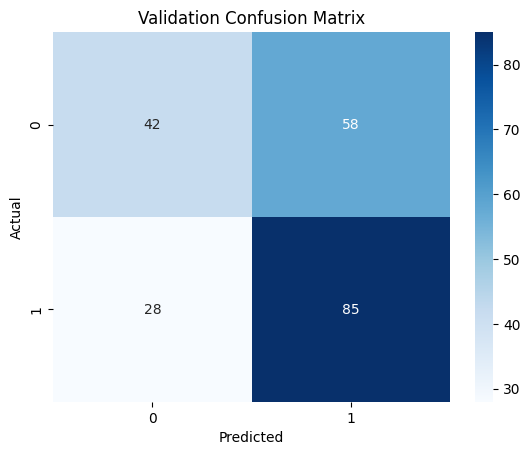


========== Test Confusion Matrix ==========


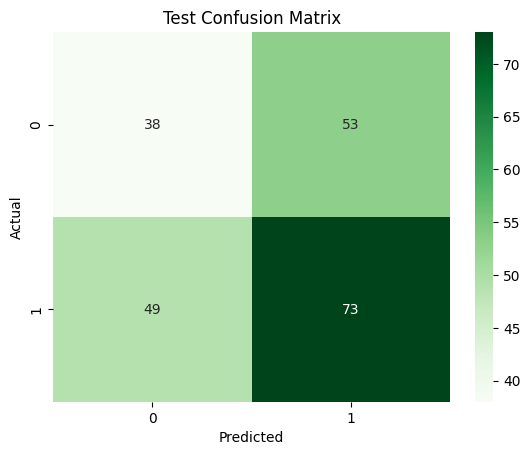

<Figure size 1200x600 with 0 Axes>

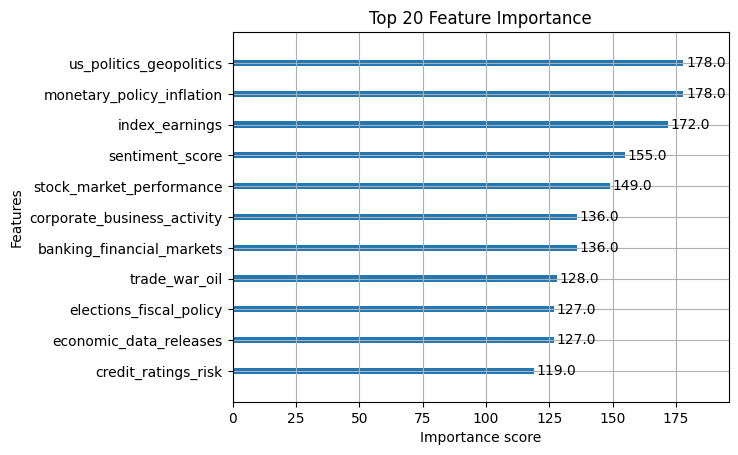

✓ Trained XGBoost model saved at: /content/drive/MyDrive/SP500_Index/Model_Training/xgboost_sp500_model.pkl


In [50]:
# =========================================================
# XGBoost Classifier for S&P 500 Index Movement Prediction first
# =========================================================

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --------------------------------------------------------
# Step 1: Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset.csv")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Step 2: Load Dataset
# --------------------------------------------------------
df = pd.read_csv(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])
print("✓ Loaded dataset:", df.shape)
print(df.head())

# --------------------------------------------------------
# Step 3: Define Features (X) and Target (y)
# --------------------------------------------------------
y = df['index_movement']
X = df.drop(columns=['date', 'index_movement'])

# --------------------------------------------------------
# Step 4: Split Dataset (Train 60%, Validation 20%, Test 20%)
# --------------------------------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 * 0.8 = 0.2

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# --------------------------------------------------------
# Step 5: Define XGBoost Classifier with Early Stopping Parameter
# --------------------------------------------------------
# Solution: Move early_stopping_rounds to the XGBClassifier constructor
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=50,  # Add early stopping parameter here
    callbacks=None  # Optional: specify callbacks if needed
)

# --------------------------------------------------------
# Step 6: Train Model with Early Stopping on Validation Set
# --------------------------------------------------------
# Solution: Pass eval_set directly, early_stopping_rounds is already set in the constructor
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# --------------------------------------------------------
# Step 7: Predictions
# --------------------------------------------------------
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# --------------------------------------------------------
# Step 8: Accuracy
# --------------------------------------------------------
print("\n========== Accuracy ==========")
print(f"Training Accuracy   : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy : {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy       : {accuracy_score(y_test, y_test_pred):.4f}")

# --------------------------------------------------------
# Step 9: Classification Reports
# --------------------------------------------------------
print("\n========== Validation Classification Report ==========")
print(classification_report(y_val, y_val_pred))

print("\n========== Test Classification Report ==========")
print(classification_report(y_test, y_test_pred))

# --------------------------------------------------------
# Step 10: Confusion Matrices
# --------------------------------------------------------
print("\n========== Validation Confusion Matrix ==========")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

print("\n========== Test Confusion Matrix ==========")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

# --------------------------------------------------------
# Step 11: Feature Importance
# --------------------------------------------------------
plt.figure(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, importance_type='weight')
plt.title('Top 20 Feature Importance')
plt.show()

# --------------------------------------------------------
# Step 12: Save Trained Model
# --------------------------------------------------------
MODEL_FILE = os.path.join(OUTPUT_DIR, "xgboost_sp500_model.pkl")
joblib.dump(model, MODEL_FILE)
print(f"✓ Trained XGBoost model saved at: {MODEL_FILE}")

✓ Loaded dataset: (1063, 13)
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                0.000000   
4                   0.206299                 0.005007                0.000000  

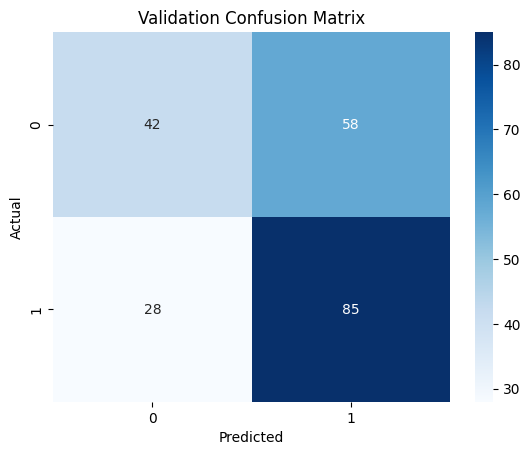


========== Test Confusion Matrix ==========


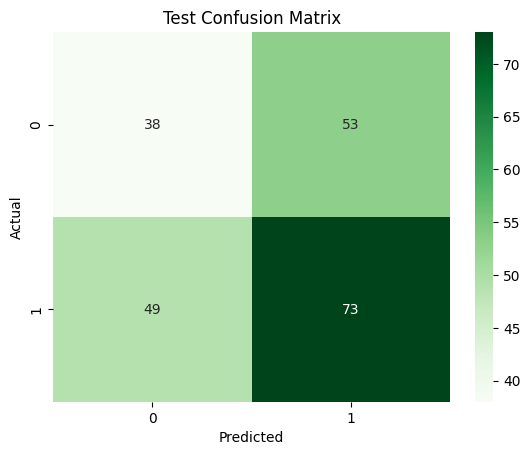

<Figure size 1200x600 with 0 Axes>

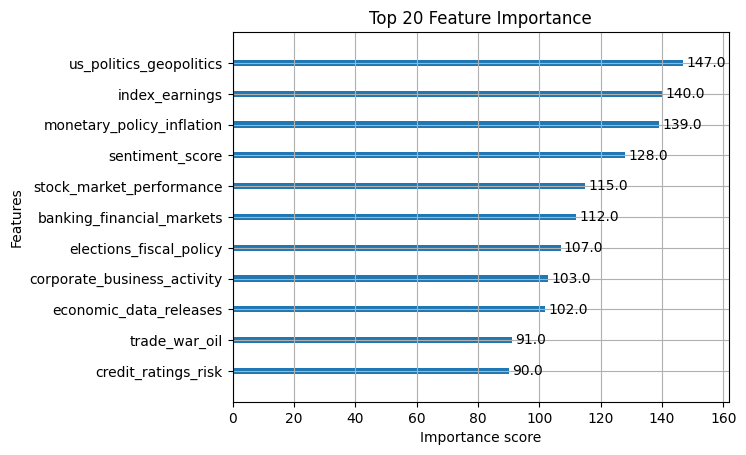

✓ Trained XGBoost model saved at: /content/drive/MyDrive/SP500_Index/Model_Training/xgboost_sp500_model.pkl


In [51]:
# =========================================================
# XGBoost Classifier for S&P 500 Index Movement Prediction
# =========================================================

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --------------------------------------------------------
# Step 1: Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset_tf.csv")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Step 2: Load Dataset
# --------------------------------------------------------
df = pd.read_csv(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])
print("✓ Loaded dataset:", df.shape)
print(df.head())

# --------------------------------------------------------
# Step 3: Define Features (X) and Target (y)
# --------------------------------------------------------
y = df['index_movement']
X = df.drop(columns=['date', 'index_movement'])

# --------------------------------------------------------
# Step 4: Split Dataset (Train 60%, Validation 20%, Test 20%)
# --------------------------------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 * 0.8 = 0.2

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# --------------------------------------------------------
# Step 5: Define XGBoost Classifier with Early Stopping Parameter
# --------------------------------------------------------
# Solution: Move early_stopping_rounds to the XGBClassifier constructor
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20,  # Add early stopping parameter here
    callbacks=None  # Optional: specify callbacks if needed
)

# --------------------------------------------------------
# Step 6: Train Model with Early Stopping on Validation Set
# --------------------------------------------------------
# Solution: Pass eval_set directly, early_stopping_rounds is already set in the constructor
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# --------------------------------------------------------
# Step 7: Predictions
# --------------------------------------------------------
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# --------------------------------------------------------
# Step 8: Accuracy
# --------------------------------------------------------
print("\n========== Accuracy ==========")
print(f"Training Accuracy   : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy : {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy       : {accuracy_score(y_test, y_test_pred):.4f}")

# --------------------------------------------------------
# Step 9: Classification Reports
# --------------------------------------------------------
print("\n========== Validation Classification Report ==========")
print(classification_report(y_val, y_val_pred))

print("\n========== Test Classification Report ==========")
print(classification_report(y_test, y_test_pred))

# --------------------------------------------------------
# Step 10: Confusion Matrices
# --------------------------------------------------------
print("\n========== Validation Confusion Matrix ==========")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

print("\n========== Test Confusion Matrix ==========")
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

# --------------------------------------------------------
# Step 11: Feature Importance
# --------------------------------------------------------
plt.figure(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, importance_type='weight')
plt.title('Top 20 Feature Importance')
plt.show()

# --------------------------------------------------------
# Step 12: Save Trained Model
# --------------------------------------------------------
MODEL_FILE = os.path.join(OUTPUT_DIR, "xgboost_sp500_model.pkl")
joblib.dump(model, MODEL_FILE)
print(f"✓ Trained XGBoost model saved at: {MODEL_FILE}")

✓ Loaded dataset: (1063, 13)

First 5 rows:
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                0.000000   
4                   0.206299                 0.005007           

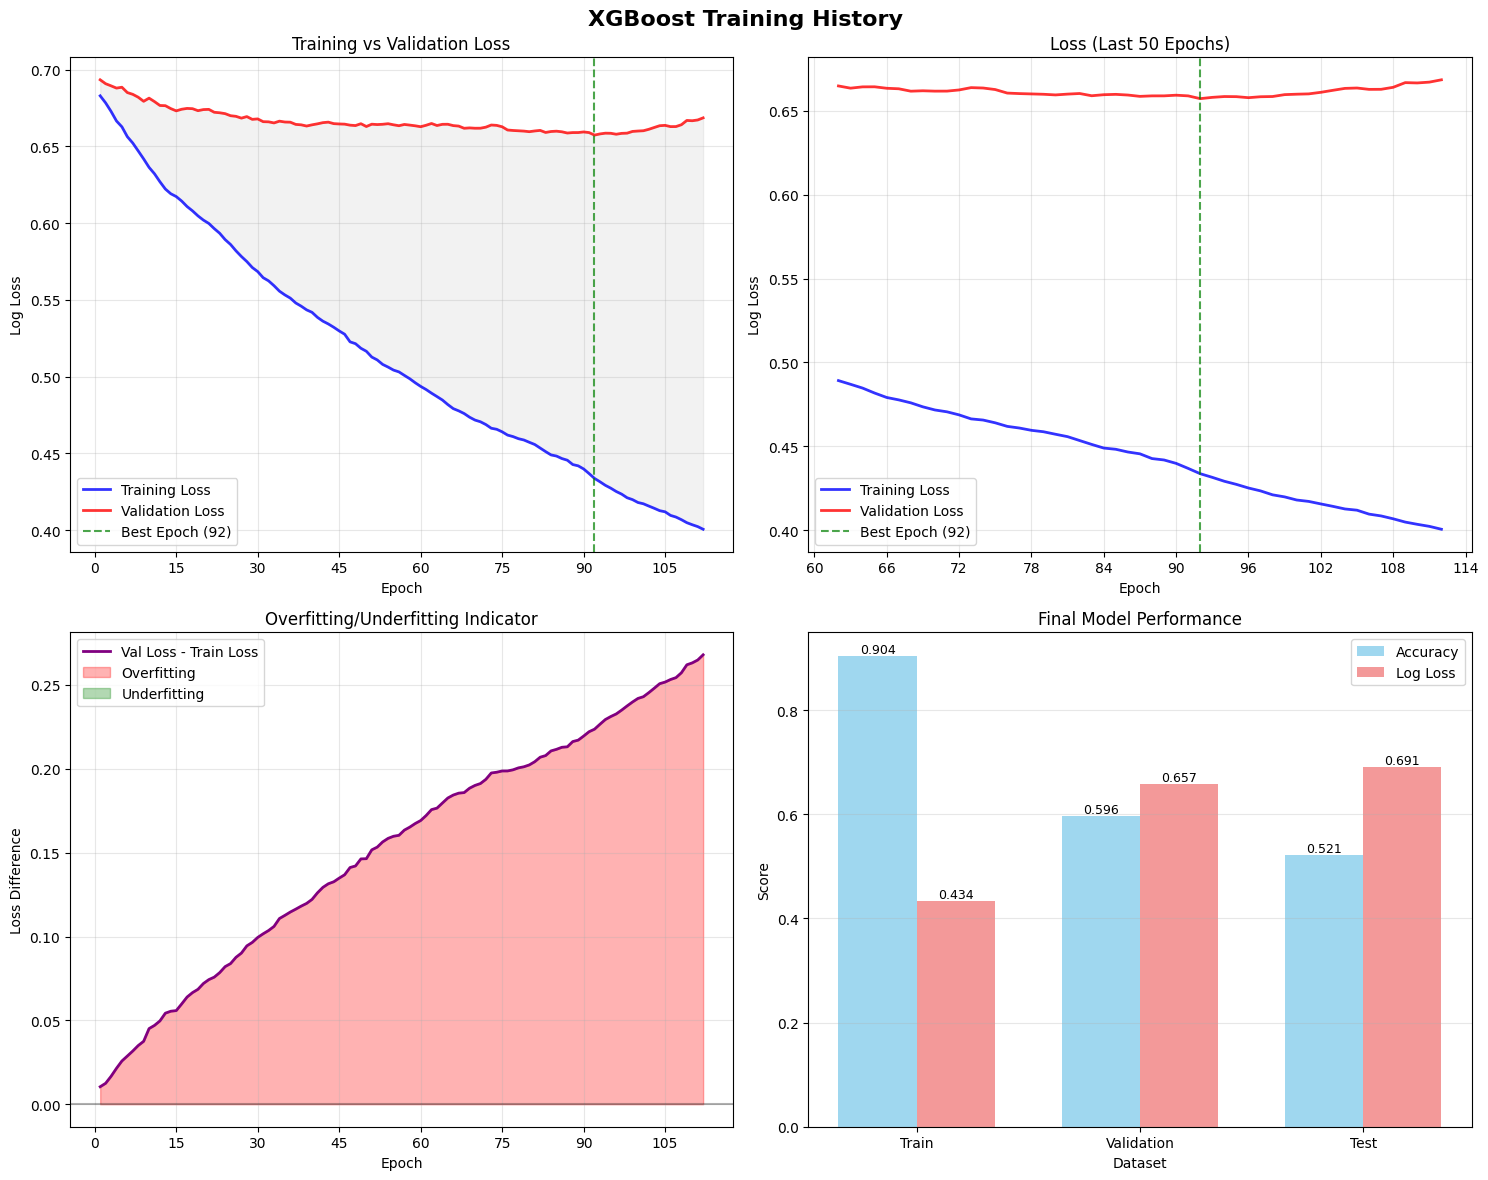


DETAILED METRICS

📊 FINAL MODEL PERFORMANCE:
----------------------------------------

Train Set:
  Accuracy: 0.9042
  Log Loss: 0.4337

Validation Set:
  Accuracy: 0.5962
  Log Loss: 0.6573

Test Set:
  Accuracy: 0.5211
  Log Loss: 0.6914

🎯 BEST MODEL (Epoch 92):
  Training Loss: 0.4337
  Validation Loss: 0.6573

CLASSIFICATION REPORTS

✅ Validation Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0     0.6000    0.4200    0.4941       100
           1     0.5944    0.7522    0.6641       113

    accuracy                         0.5962       213
   macro avg     0.5972    0.5861    0.5791       213
weighted avg     0.5970    0.5962    0.5843       213


✅ Test Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0     0.4368    0.4176    0.4270        91
           1     0.5794    0.5984    0.5887       122

    accuracy      

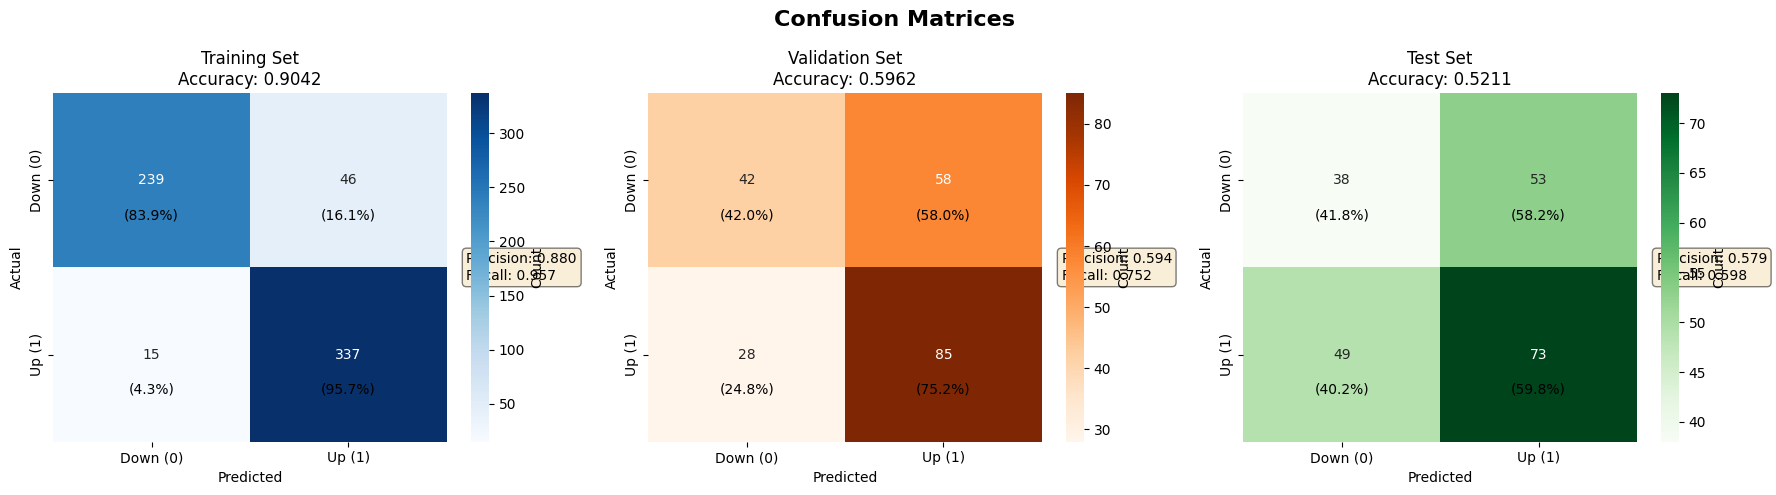


FEATURE IMPORTANCE ANALYSIS


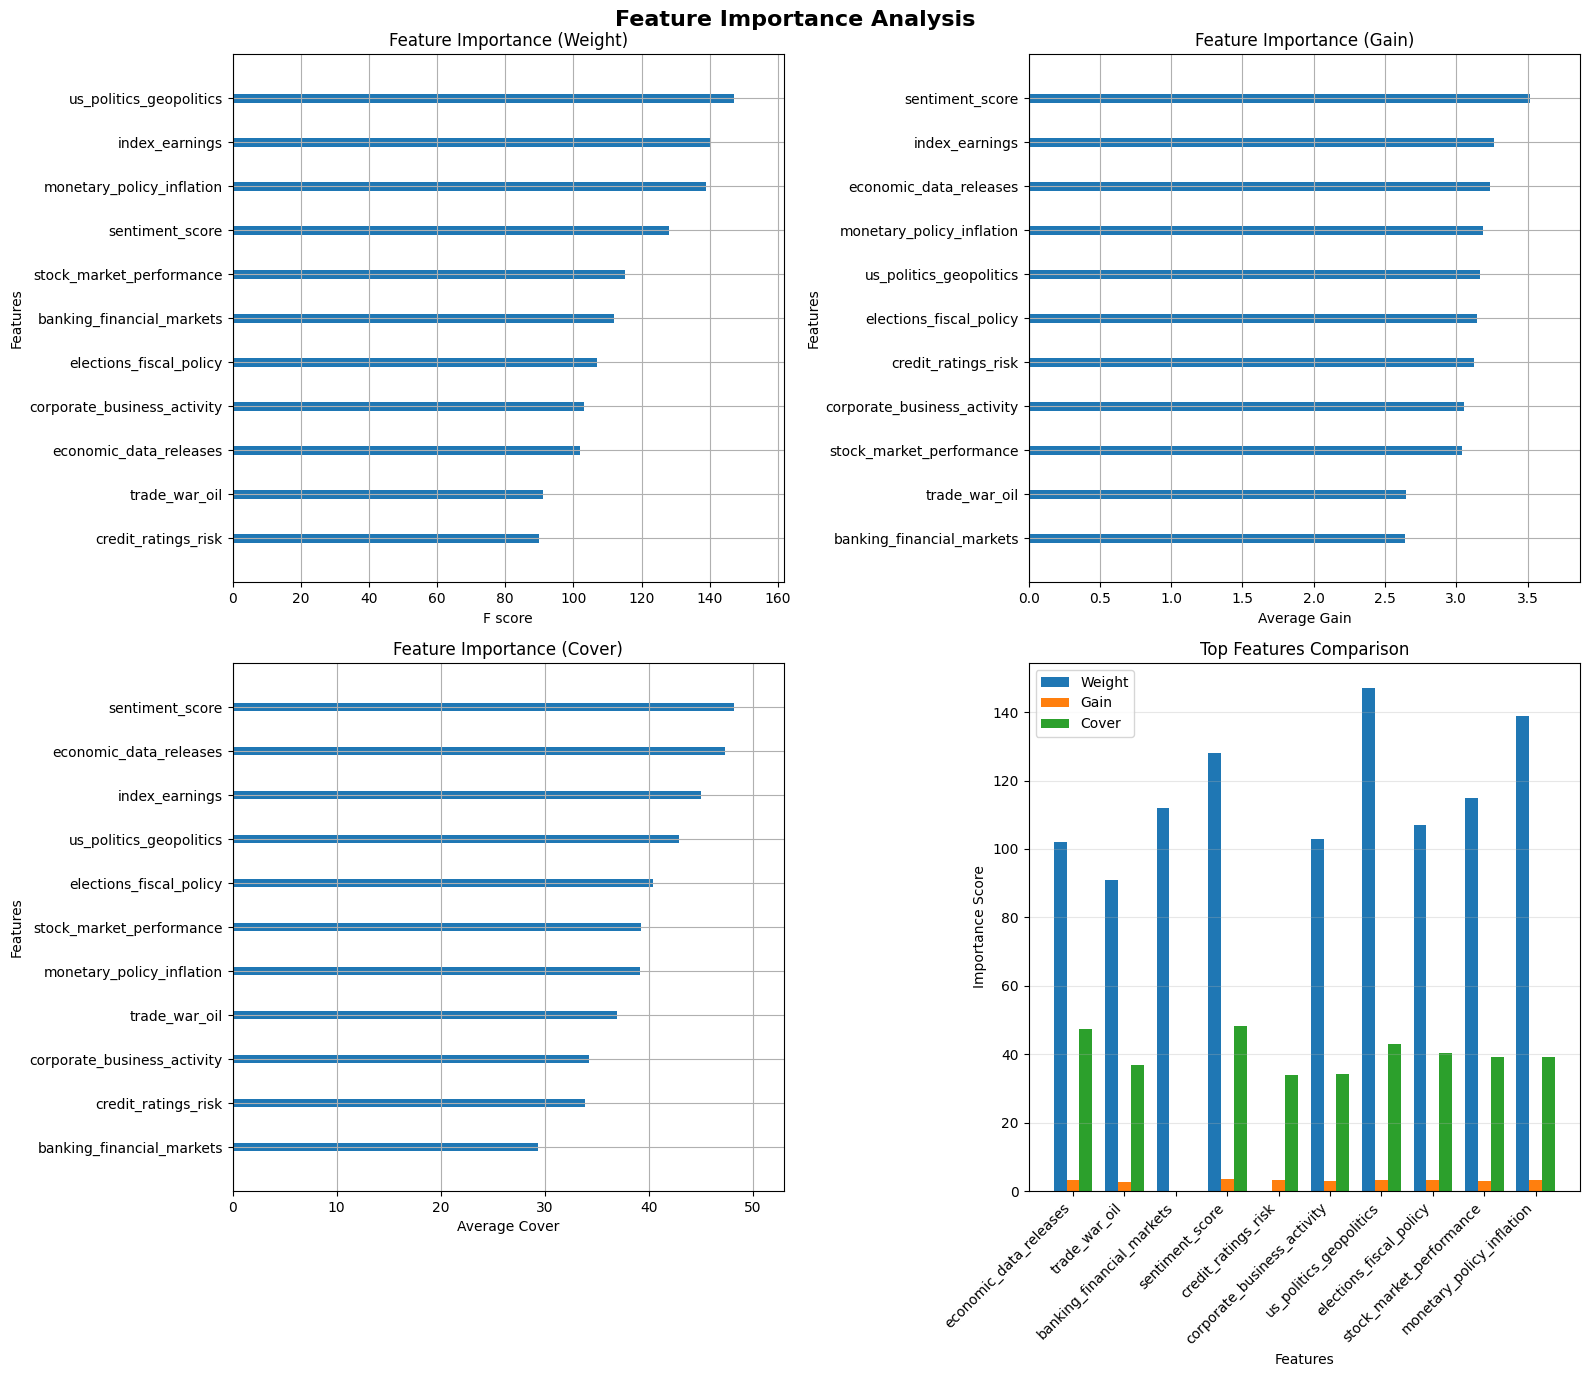


🏆 TOP 10 MOST IMPORTANT FEATURES:
----------------------------------------

GAIN Importance:
   1. sentiment_score               : 3.5165
   2. index_earnings                : 3.2618
   3. economic_data_releases        : 3.2348
   4. monetary_policy_inflation     : 3.1892
   5. us_politics_geopolitics       : 3.1677
   6. elections_fiscal_policy       : 3.1456
   7. credit_ratings_risk           : 3.1274
   8. corporate_business_activity   : 3.0526
   9. stock_market_performance      : 3.0388
  10. trade_war_oil                 : 2.6493

WEIGHT Importance:
   1. us_politics_geopolitics       : 147.0000
   2. index_earnings                : 140.0000
   3. monetary_policy_inflation     : 139.0000
   4. sentiment_score               : 128.0000
   5. stock_market_performance      : 115.0000
   6. banking_financial_markets     : 112.0000
   7. elections_fiscal_policy       : 107.0000
   8. corporate_business_activity   : 103.0000
   9. economic_data_releases        : 102.0000
  10. trade_w

ValueError: All arrays must be of the same length

In [52]:
# =========================================================
# XGBoost Classifier with Training/Validation Tracking
# =========================================================

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.ticker import MaxNLocator

# --------------------------------------------------------
# Step 1: Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset_tf.csv")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Step 2: Load Dataset
# --------------------------------------------------------
df = pd.read_csv(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])
print("✓ Loaded dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# --------------------------------------------------------
# Step 3: Define Features (X) and Target (y)
# --------------------------------------------------------
y = df['index_movement']
X = df.drop(columns=['date', 'index_movement'])

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Target distribution:\n{y.value_counts()}")
print(f"✓ Positive class percentage: {y.mean():.2%}")

# --------------------------------------------------------
# Step 4: Split Dataset (Train 60%, Validation 20%, Test 20%)
# --------------------------------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 * 0.8 = 0.2

print(f"\n✓ Dataset split:")
print(f"  Train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# --------------------------------------------------------
# Step 5: Initialize XGBoost Model
# --------------------------------------------------------
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20
)

# --------------------------------------------------------
# Step 6: Train Model and Track Metrics
# --------------------------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL WITH EARLY STOPPING")
print("="*50)

# Train the model
history = model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=10  # Print every 10 iterations
)

# --------------------------------------------------------
# Step 7: Extract Training History
# --------------------------------------------------------
print("\n" + "="*50)
print("EXTRACTING TRAINING HISTORY")
print("="*50)

# Get the evaluation results
eval_results = model.evals_result()
train_logloss = eval_results['validation_0']['logloss']
val_logloss = eval_results['validation_1']['logloss']

# Get predictions for accuracy calculation
train_pred_proba = model.predict_proba(X_train)[:, 1]
val_pred_proba = model.predict_proba(X_val)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

train_pred = (train_pred_proba > 0.5).astype(int)
val_pred = (val_pred_proba > 0.5).astype(int)
test_pred = (test_pred_proba > 0.5).astype(int)

# Calculate accuracies per epoch
train_accuracies = []
val_accuracies = []

# For multi-class, we would need to track predictions at each iteration
# For binary classification, we can only get final predictions
# So we'll create a function to get metrics history
def get_metrics_history():
    """Extract metrics from training history"""
    metrics = {
        'epoch': list(range(1, len(train_logloss) + 1)),
        'train_loss': train_logloss,
        'val_loss': val_logloss,
    }

    # Create a DataFrame
    history_df = pd.DataFrame(metrics)

    # Find best epoch
    best_epoch = history_df['val_loss'].idxmin() + 1
    history_df['best_epoch'] = (history_df.index + 1) == best_epoch

    return history_df, best_epoch

# Get history dataframe
history_df, best_epoch = get_metrics_history()

print(f"\n✓ Training stopped at epoch: {len(train_logloss)}")
print(f"✓ Best epoch: {best_epoch} (validation loss: {min(val_logloss):.4f})")

# --------------------------------------------------------
# Step 8: Plot Training History
# --------------------------------------------------------
print("\n" + "="*50)
print("PLOTTING TRAINING HISTORY")
print("="*50)

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('XGBoost Training History', fontsize=16, fontweight='bold')

# 1. Loss Curves
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'],
                label='Training Loss', linewidth=2, color='blue', alpha=0.8)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'],
                label='Validation Loss', linewidth=2, color='red', alpha=0.8)
axes[0, 0].axvline(x=best_epoch, color='green', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 0].fill_between(history_df['epoch'], history_df['train_loss'],
                        history_df['val_loss'], alpha=0.1, color='gray')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Log Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. Zoomed Loss (Last 50 epochs if available)
if len(history_df) > 50:
    zoom_start = max(1, len(history_df) - 50)
    zoom_df = history_df.iloc[zoom_start-1:]

    axes[0, 1].plot(zoom_df['epoch'], zoom_df['train_loss'],
                    label='Training Loss', linewidth=2, color='blue', alpha=0.8)
    axes[0, 1].plot(zoom_df['epoch'], zoom_df['val_loss'],
                    label='Validation Loss', linewidth=2, color='red', alpha=0.8)
    axes[0, 1].axvline(x=best_epoch, color='green', linestyle='--',
                       label=f'Best Epoch ({best_epoch})', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Log Loss')
    axes[0, 1].set_title('Loss (Last 50 Epochs)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))
else:
    axes[0, 1].text(0.5, 0.5, 'Not enough epochs for zoom',
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Zoomed Loss View')

# 3. Loss Difference
loss_diff = np.array(history_df['val_loss']) - np.array(history_df['train_loss'])
axes[1, 0].plot(history_df['epoch'], loss_diff,
                label='Val Loss - Train Loss', linewidth=2, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].fill_between(history_df['epoch'], 0, loss_diff,
                        where=(loss_diff > 0), alpha=0.3, color='red', label='Overfitting')
axes[1, 0].fill_between(history_df['epoch'], 0, loss_diff,
                        where=(loss_diff < 0), alpha=0.3, color='green', label='Underfitting')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Difference')
axes[1, 0].set_title('Overfitting/Underfitting Indicator')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 4. Final Metrics Comparison
metrics_data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, train_pred),
        accuracy_score(y_val, val_pred),
        accuracy_score(y_test, test_pred)
    ],
    'Log Loss': [
        log_loss(y_train, train_pred_proba),
        log_loss(y_val, val_pred_proba),
        log_loss(y_test, test_pred_proba)
    ]
}

metrics_df = pd.DataFrame(metrics_data)
x = np.arange(len(metrics_df))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, metrics_df['Accuracy'], width,
                       label='Accuracy', color='skyblue', alpha=0.8)
bars2 = axes[1, 1].bar(x + width/2, metrics_df['Log Loss'], width,
                       label='Log Loss', color='lightcoral', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Final Model Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df['Dataset'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------
# Step 9: Print Detailed Metrics
# --------------------------------------------------------
print("\n" + "="*50)
print("DETAILED METRICS")
print("="*50)

print(f"\n📊 FINAL MODEL PERFORMANCE:")
print("-" * 40)

for idx, row in metrics_df.iterrows():
    print(f"\n{row['Dataset']} Set:")
    print(f"  Accuracy: {row['Accuracy']:.4f}")
    print(f"  Log Loss: {row['Log Loss']:.4f}")

print(f"\n🎯 BEST MODEL (Epoch {best_epoch}):")
print(f"  Training Loss: {train_logloss[best_epoch-1]:.4f}")
print(f"  Validation Loss: {val_logloss[best_epoch-1]:.4f}")

# --------------------------------------------------------
# Step 10: Classification Reports
# --------------------------------------------------------
print("\n" + "="*50)
print("CLASSIFICATION REPORTS")
print("="*50)

print("\n✅ Validation Classification Report:")
print("-" * 40)
print(classification_report(y_val, val_pred, digits=4))

print("\n✅ Test Classification Report:")
print("-" * 40)
print(classification_report(y_test, test_pred, digits=4))

# --------------------------------------------------------
# Step 11: Confusion Matrices
# --------------------------------------------------------
print("\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

datasets = [
    ('Training', y_train, train_pred, 'Blues'),
    ('Validation', y_val, val_pred, 'Oranges'),
    ('Test', y_test, test_pred, 'Greens')
]

for idx, (title, y_true, y_pred, cmap) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Down (0)', 'Up (1)'],
                yticklabels=['Down (0)', 'Up (1)'],
                ax=axes[idx], cbar_kws={'label': 'Count'})

    # Add percentage annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)',
                          ha='center', va='center', color='black', fontsize=10)

    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{title} Set\nAccuracy: {accuracy_score(y_true, y_pred):.4f}')

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    metrics_text = f"Precision: {precision:.3f}\nRecall: {recall:.3f}"
    axes[idx].text(1.05, 0.5, metrics_text, transform=axes[idx].transAxes,
                  verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------
# Step 12: Feature Importance Analysis
# --------------------------------------------------------
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# 1. Weight-based importance
xgb.plot_importance(model, importance_type='weight', max_num_features=15,
                    title='Feature Importance (Weight)', ax=axes[0, 0],
                    xlabel='F score', show_values=False)

# 2. Gain-based importance
xgb.plot_importance(model, importance_type='gain', max_num_features=15,
                    title='Feature Importance (Gain)', ax=axes[0, 1],
                    xlabel='Average Gain', show_values=False)

# 3. Cover-based importance
xgb.plot_importance(model, importance_type='cover', max_num_features=15,
                    title='Feature Importance (Cover)', ax=axes[1, 0],
                    xlabel='Average Cover', show_values=False)

# 4. Top 10 features comparison
importance_types = ['weight', 'gain', 'cover']
importance_data = {}

for imp_type in importance_types:
    importance = model.get_booster().get_score(importance_type=imp_type)
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    importance_data[imp_type] = dict(sorted_features)

# Create comparison plot
all_features = set()
for imp_type in importance_types:
    all_features.update(importance_data[imp_type].keys())

all_features = list(all_features)[:10]  # Take top 10 unique features

x = np.arange(len(all_features))
width = 0.25

for idx, imp_type in enumerate(importance_types):
    values = [importance_data[imp_type].get(feature, 0) for feature in all_features]
    axes[1, 1].bar(x + idx*width, values, width, label=imp_type.capitalize())

axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Importance Score')
axes[1, 1].set_title('Top Features Comparison')
axes[1, 1].set_xticks(x + width)
axes[1, 1].set_xticklabels(all_features, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 40)
for imp_type in ['gain', 'weight', 'cover']:
    importance = model.get_booster().get_score(importance_type=imp_type)
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n{imp_type.upper()} Importance:")
    for i, (feature, score) in enumerate(sorted_features, 1):
        print(f"  {i:2d}. {feature:30s}: {score:.4f}")

# --------------------------------------------------------
# Step 13: Save Everything
# --------------------------------------------------------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save model
MODEL_FILE = os.path.join(OUTPUT_DIR, "xgboost_sp500_model.pkl")
joblib.dump(model, MODEL_FILE)
print(f"✓ Model saved: {MODEL_FILE}")

# Save training history
HISTORY_FILE = os.path.join(OUTPUT_DIR, "training_history.csv")
history_df.to_csv(HISTORY_FILE, index=False)
print(f"✓ Training history saved: {HISTORY_FILE}")

# Save predictions
predictions_df = pd.DataFrame({
    'y_train_true': y_train.values,
    'y_train_pred': train_pred,
    'y_train_proba': train_pred_proba,
    'y_val_true': y_val.values,
    'y_val_pred': val_pred,
    'y_val_proba': val_pred_proba,
    'y_test_true': y_test.values,
    'y_test_pred': test_pred,
    'y_test_proba': test_pred_proba
})

PREDICTIONS_FILE = os.path.join(OUTPUT_DIR, "predictions.csv")
predictions_df.to_csv(PREDICTIONS_FILE, index=False)
print(f"✓ Predictions saved: {PREDICTIONS_FILE}")

# Save metrics summary
summary = {
    'best_epoch': best_epoch,
    'train_accuracy': accuracy_score(y_train, train_pred),
    'val_accuracy': accuracy_score(y_val, val_pred),
    'test_accuracy': accuracy_score(y_test, test_pred),
    'train_loss': log_loss(y_train, train_pred_proba),
    'val_loss': log_loss(y_val, val_pred_proba),
    'test_loss': log_loss(y_test, test_pred_proba),
    'total_training_time_epochs': len(train_logloss)
}

summary_df = pd.DataFrame([summary])
SUMMARY_FILE = os.path.join(OUTPUT_DIR, "model_summary.csv")
summary_df.to_csv(SUMMARY_FILE, index=False)
print(f"✓ Model summary saved: {SUMMARY_FILE}")

print("\n" + "="*50)
print("TRAINING COMPLETE! ✅")
print("="*50)
print(f"\n📁 All files saved in: {OUTPUT_DIR}")
print(f"📊 Final Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"📉 Final Test Loss: {log_loss(y_test, test_pred_proba):.4f}")

✓ Loaded dataset: (1063, 24)

First 5 rows:
        date  sentiment_score  credit_ratings_risk  monetary_policy_inflation  \
0 2016-01-05         0.240512             0.007816                   0.002835   
1 2016-01-06        -0.015910             0.000000                   0.294297   
2 2016-01-07         0.033551             0.083276                   0.323154   
3 2016-01-08        -0.252731             0.083256                   0.166097   
4 2016-01-11        -0.198418             0.000000                   0.213684   

   banking_financial_markets  us_politics_geopolitics  economic_data_releases  \
0                   0.239583                 0.067903                0.002924   
1                   0.248765                 0.012509                0.000000   
2                   0.121158                 0.096247                0.000000   
3                   0.163780                 0.089953                0.000000   
4                   0.206299                 0.005007           

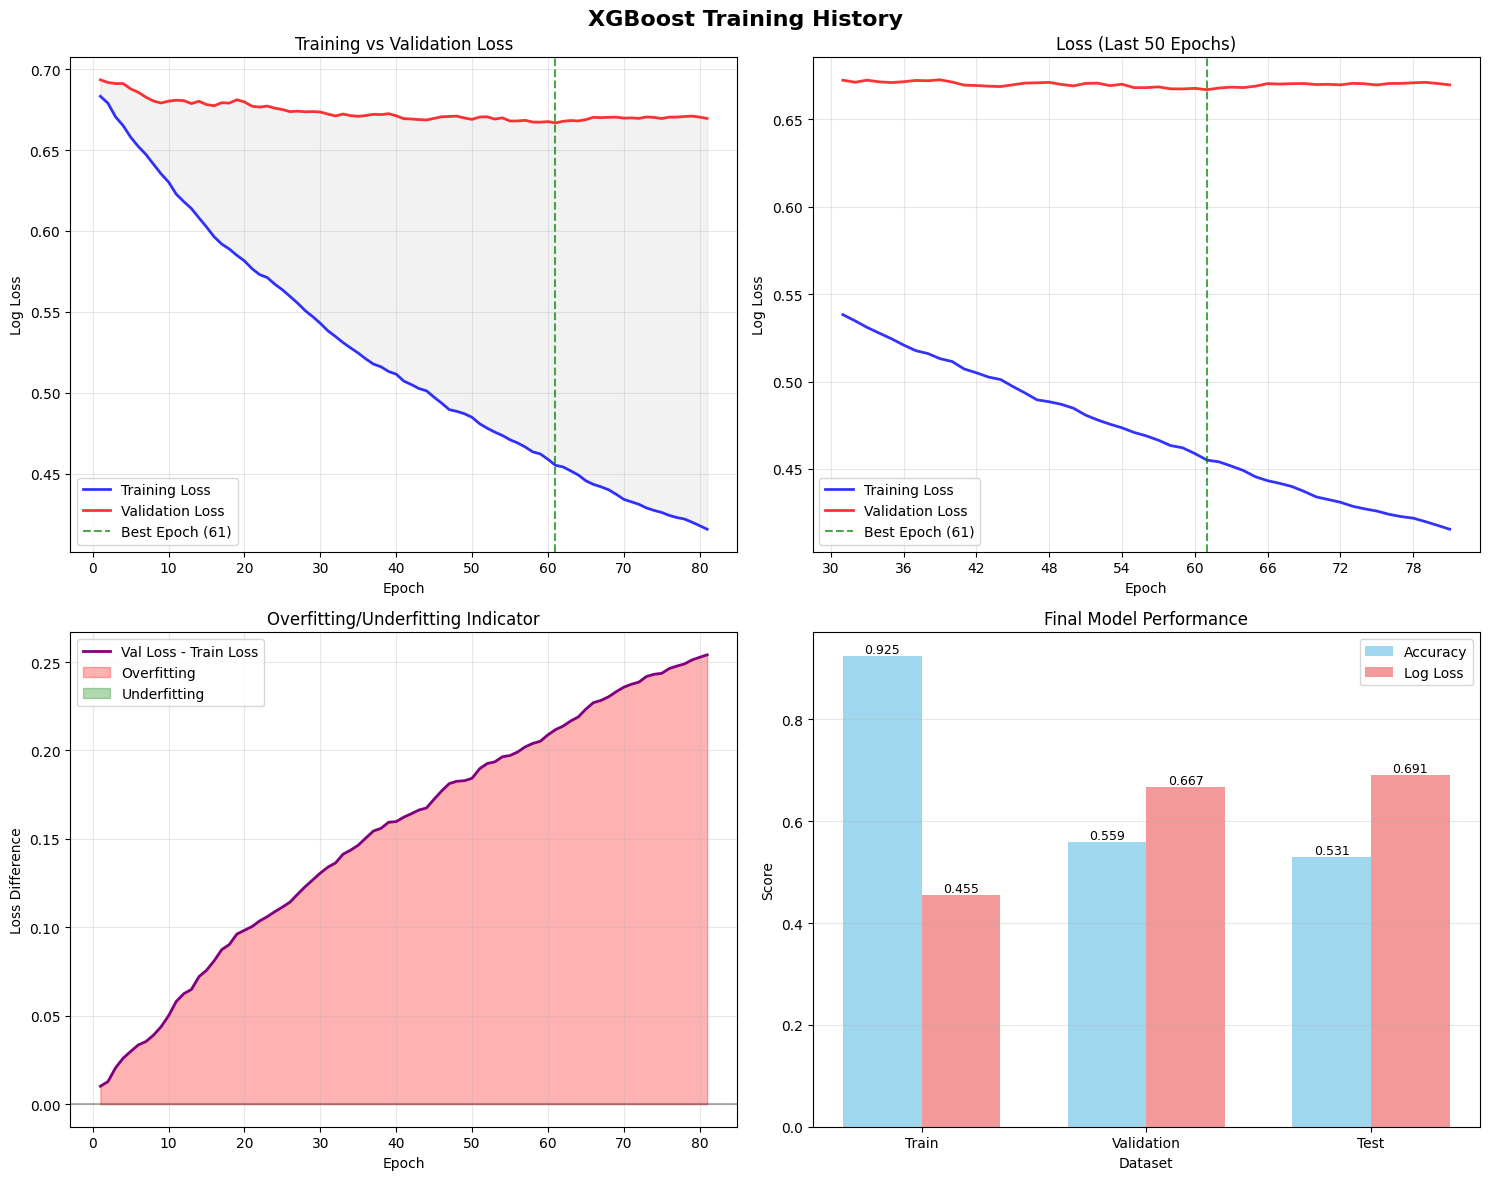


DETAILED METRICS

📊 FINAL MODEL PERFORMANCE:
----------------------------------------

Train Set:
  Accuracy: 0.9246
  Log Loss: 0.4551

Validation Set:
  Accuracy: 0.5587
  Log Loss: 0.6668

Test Set:
  Accuracy: 0.5305
  Log Loss: 0.6915

🎯 BEST MODEL (Epoch 61):
  Training Loss: 0.4551
  Validation Loss: 0.6668

CLASSIFICATION REPORTS

✅ Validation Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0     0.5441    0.3700    0.4405       100
           1     0.5655    0.7257    0.6357       113

    accuracy                         0.5587       213
   macro avg     0.5548    0.5478    0.5381       213
weighted avg     0.5555    0.5587    0.5440       213


✅ Test Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0     0.4471    0.4176    0.4318        91
           1     0.5859    0.6148    0.6000       122

    accuracy      

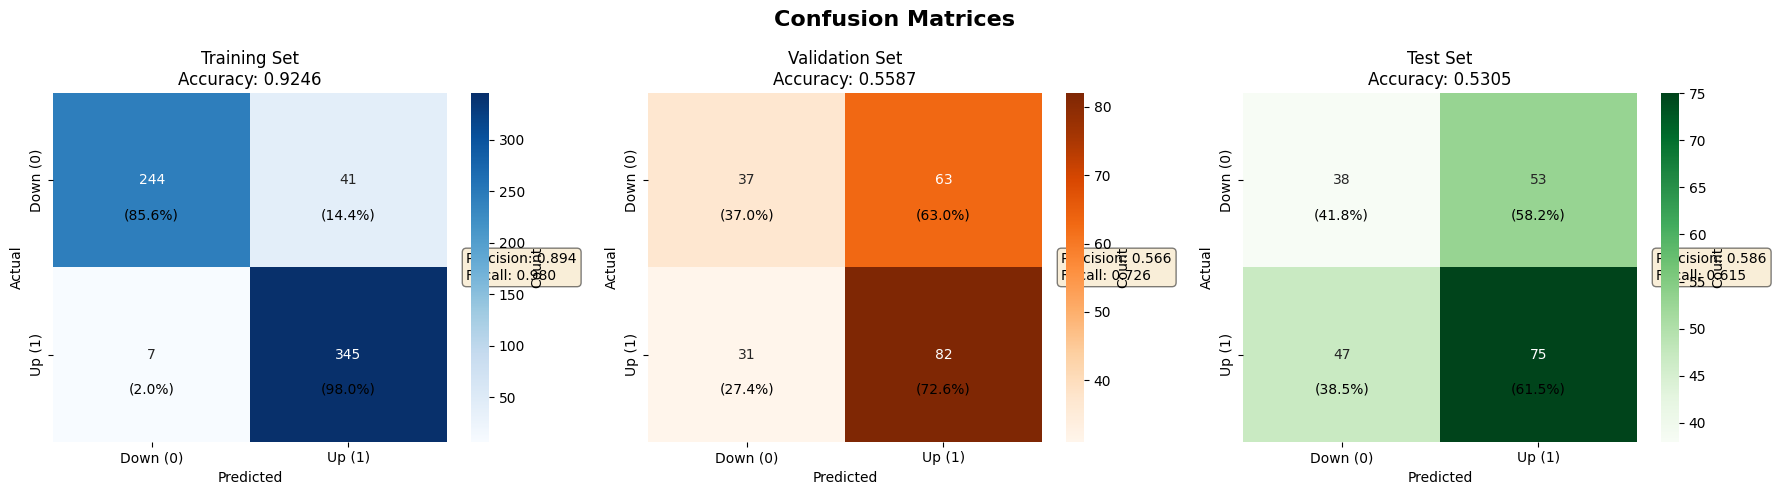


FEATURE IMPORTANCE ANALYSIS


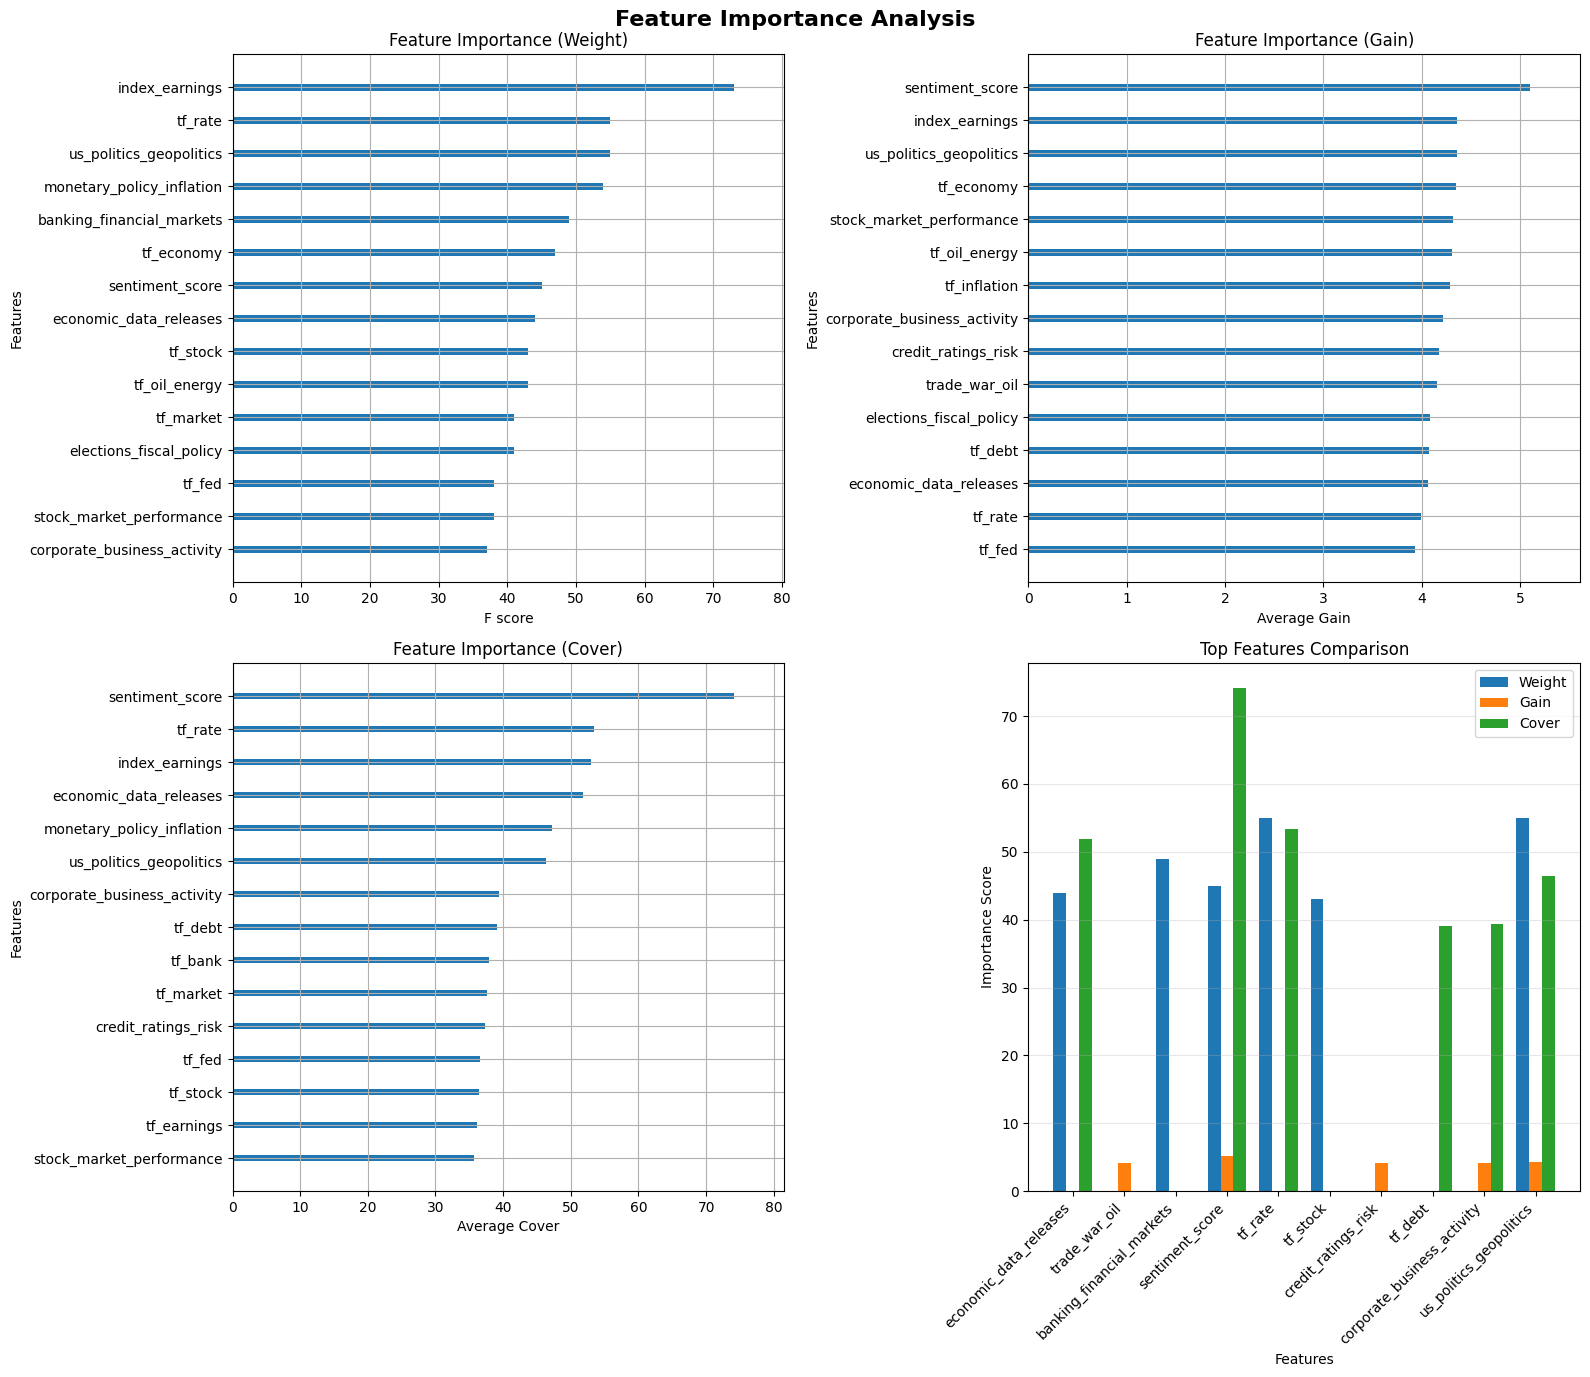


🏆 TOP 10 MOST IMPORTANT FEATURES:
----------------------------------------

GAIN Importance:
   1. sentiment_score               : 5.0985
   2. index_earnings                : 4.3602
   3. us_politics_geopolitics       : 4.3583
   4. tf_economy                    : 4.3474
   5. stock_market_performance      : 4.3147
   6. tf_oil_energy                 : 4.3070
   7. tf_inflation                  : 4.2845
   8. corporate_business_activity   : 4.2111
   9. credit_ratings_risk           : 4.1721
  10. trade_war_oil                 : 4.1524

WEIGHT Importance:
   1. index_earnings                : 73.0000
   2. us_politics_geopolitics       : 55.0000
   3. tf_rate                       : 55.0000
   4. monetary_policy_inflation     : 54.0000
   5. banking_financial_markets     : 49.0000
   6. tf_economy                    : 47.0000
   7. sentiment_score               : 45.0000
   8. economic_data_releases        : 44.0000
   9. tf_oil_energy                 : 43.0000
  10. tf_stock        

ValueError: cannot convert float NaN to integer

In [39]:
# =========================================================
# XGBoost Classifier with Training/Validation Tracking - FIXED VERSION
# =========================================================

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.ticker import MaxNLocator

# --------------------------------------------------------
# Step 1: Paths
# --------------------------------------------------------
PROJECT_PATH = "/content/drive/MyDrive/SP500_Index"
INPUT_FILE = os.path.join(PROJECT_PATH, "Model_Training", "XGBoost_final_dataset.csv")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "Model_Training")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------------
# Step 2: Load Dataset
# --------------------------------------------------------
df = pd.read_csv(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])
print("✓ Loaded dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# --------------------------------------------------------
# Step 3: Define Features (X) and Target (y)
# --------------------------------------------------------
y = df['index_movement']
X = df.drop(columns=['date', 'index_movement'])

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Target distribution:\n{y.value_counts()}")
print(f"✓ Positive class percentage: {y.mean():.2%}")

# --------------------------------------------------------
# Step 4: Split Dataset (Train 60%, Validation 20%, Test 20%)
# --------------------------------------------------------
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False
)  # 0.25 * 0.8 = 0.2

print(f"\n✓ Dataset split:")
print(f"  Train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# --------------------------------------------------------
# Step 5: Initialize XGBoost Model
# --------------------------------------------------------
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20
)

# --------------------------------------------------------
# Step 6: Train Model and Track Metrics
# --------------------------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL WITH EARLY STOPPING")
print("="*50)

# Train the model
history = model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=10  # Print every 10 iterations
)

# --------------------------------------------------------
# Step 7: Extract Training History
# --------------------------------------------------------
print("\n" + "="*50)
print("EXTRACTING TRAINING HISTORY")
print("="*50)

# Get the evaluation results
eval_results = model.evals_result()
train_logloss = eval_results['validation_0']['logloss']
val_logloss = eval_results['validation_1']['logloss']

# Get predictions for accuracy calculation
train_pred_proba = model.predict_proba(X_train)[:, 1]
val_pred_proba = model.predict_proba(X_val)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

train_pred = (train_pred_proba > 0.5).astype(int)
val_pred = (val_pred_proba > 0.5).astype(int)
test_pred = (test_pred_proba > 0.5).astype(int)

# Calculate accuracies per epoch
train_accuracies = []
val_accuracies = []

# For multi-class, we would need to track predictions at each iteration
# For binary classification, we can only get final predictions
# So we'll create a function to get metrics history
def get_metrics_history():
    """Extract metrics from training history"""
    metrics = {
        'epoch': list(range(1, len(train_logloss) + 1)),
        'train_loss': train_logloss,
        'val_loss': val_logloss,
    }

    # Create a DataFrame
    history_df = pd.DataFrame(metrics)

    # Find best epoch
    best_epoch = history_df['val_loss'].idxmin() + 1
    history_df['best_epoch'] = (history_df.index + 1) == best_epoch

    return history_df, best_epoch

# Get history dataframe
history_df, best_epoch = get_metrics_history()

print(f"\n✓ Training stopped at epoch: {len(train_logloss)}")
print(f"✓ Best epoch: {best_epoch} (validation loss: {min(val_logloss):.4f})")

# --------------------------------------------------------
# Step 8: Plot Training History
# --------------------------------------------------------
print("\n" + "="*50)
print("PLOTTING TRAINING HISTORY")
print("="*50)

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('XGBoost Training History', fontsize=16, fontweight='bold')

# 1. Loss Curves
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'],
                label='Training Loss', linewidth=2, color='blue', alpha=0.8)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'],
                label='Validation Loss', linewidth=2, color='red', alpha=0.8)
axes[0, 0].axvline(x=best_epoch, color='green', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 0].fill_between(history_df['epoch'], history_df['train_loss'],
                        history_df['val_loss'], alpha=0.1, color='gray')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Log Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. Zoomed Loss (Last 50 epochs if available)
if len(history_df) > 50:
    zoom_start = max(1, len(history_df) - 50)
    zoom_df = history_df.iloc[zoom_start-1:]

    axes[0, 1].plot(zoom_df['epoch'], zoom_df['train_loss'],
                    label='Training Loss', linewidth=2, color='blue', alpha=0.8)
    axes[0, 1].plot(zoom_df['epoch'], zoom_df['val_loss'],
                    label='Validation Loss', linewidth=2, color='red', alpha=0.8)
    axes[0, 1].axvline(x=best_epoch, color='green', linestyle='--',
                       label=f'Best Epoch ({best_epoch})', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Log Loss')
    axes[0, 1].set_title('Loss (Last 50 Epochs)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))
else:
    axes[0, 1].text(0.5, 0.5, 'Not enough epochs for zoom',
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Zoomed Loss View')

# 3. Loss Difference
loss_diff = np.array(history_df['val_loss']) - np.array(history_df['train_loss'])
axes[1, 0].plot(history_df['epoch'], loss_diff,
                label='Val Loss - Train Loss', linewidth=2, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].fill_between(history_df['epoch'], 0, loss_diff,
                        where=(loss_diff > 0), alpha=0.3, color='red', label='Overfitting')
axes[1, 0].fill_between(history_df['epoch'], 0, loss_diff,
                        where=(loss_diff < 0), alpha=0.3, color='green', label='Underfitting')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Difference')
axes[1, 0].set_title('Overfitting/Underfitting Indicator')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 4. Final Metrics Comparison
metrics_data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, train_pred),
        accuracy_score(y_val, val_pred),
        accuracy_score(y_test, test_pred)
    ],
    'Log Loss': [
        log_loss(y_train, train_pred_proba),
        log_loss(y_val, val_pred_proba),
        log_loss(y_test, test_pred_proba)
    ]
}

metrics_df = pd.DataFrame(metrics_data)
x = np.arange(len(metrics_df))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, metrics_df['Accuracy'], width,
                       label='Accuracy', color='skyblue', alpha=0.8)
bars2 = axes[1, 1].bar(x + width/2, metrics_df['Log Loss'], width,
                       label='Log Loss', color='lightcoral', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Final Model Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df['Dataset'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------
# Step 9: Print Detailed Metrics
# --------------------------------------------------------
print("\n" + "="*50)
print("DETAILED METRICS")
print("="*50)

print(f"\n📊 FINAL MODEL PERFORMANCE:")
print("-" * 40)

for idx, row in metrics_df.iterrows():
    print(f"\n{row['Dataset']} Set:")
    print(f"  Accuracy: {row['Accuracy']:.4f}")
    print(f"  Log Loss: {row['Log Loss']:.4f}")

print(f"\n🎯 BEST MODEL (Epoch {best_epoch}):")
print(f"  Training Loss: {train_logloss[best_epoch-1]:.4f}")
print(f"  Validation Loss: {val_logloss[best_epoch-1]:.4f}")

# --------------------------------------------------------
# Step 10: Classification Reports
# --------------------------------------------------------
print("\n" + "="*50)
print("CLASSIFICATION REPORTS")
print("="*50)

print("\n✅ Validation Classification Report:")
print("-" * 40)
print(classification_report(y_val, val_pred, digits=4))

print("\n✅ Test Classification Report:")
print("-" * 40)
print(classification_report(y_test, test_pred, digits=4))

# --------------------------------------------------------
# Step 11: Confusion Matrices
# --------------------------------------------------------
print("\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

datasets = [
    ('Training', y_train, train_pred, 'Blues'),
    ('Validation', y_val, val_pred, 'Oranges'),
    ('Test', y_test, test_pred, 'Greens')
]

for idx, (title, y_true, y_pred, cmap) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Down (0)', 'Up (1)'],
                yticklabels=['Down (0)', 'Up (1)'],
                ax=axes[idx], cbar_kws={'label': 'Count'})

    # Add percentage annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)',
                          ha='center', va='center', color='black', fontsize=10)

    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{title} Set\nAccuracy: {accuracy_score(y_true, y_pred):.4f}')

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    metrics_text = f"Precision: {precision:.3f}\nRecall: {recall:.3f}"
    axes[idx].text(1.05, 0.5, metrics_text, transform=axes[idx].transAxes,
                  verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------
# Step 12: Feature Importance Analysis
# --------------------------------------------------------
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# 1. Weight-based importance
xgb.plot_importance(model, importance_type='weight', max_num_features=15,
                    title='Feature Importance (Weight)', ax=axes[0, 0],
                    xlabel='F score', show_values=False)

# 2. Gain-based importance
xgb.plot_importance(model, importance_type='gain', max_num_features=15,
                    title='Feature Importance (Gain)', ax=axes[0, 1],
                    xlabel='Average Gain', show_values=False)

# 3. Cover-based importance
xgb.plot_importance(model, importance_type='cover', max_num_features=15,
                    title='Feature Importance (Cover)', ax=axes[1, 0],
                    xlabel='Average Cover', show_values=False)

# 4. Top 10 features comparison
importance_types = ['weight', 'gain', 'cover']
importance_data = {}

for imp_type in importance_types:
    importance = model.get_booster().get_score(importance_type=imp_type)
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    importance_data[imp_type] = dict(sorted_features)

# Create comparison plot
all_features = set()
for imp_type in importance_types:
    all_features.update(importance_data[imp_type].keys())

all_features = list(all_features)[:10]  # Take top 10 unique features

x = np.arange(len(all_features))
width = 0.25

for idx, imp_type in enumerate(importance_types):
    values = [importance_data[imp_type].get(feature, 0) for feature in all_features]
    axes[1, 1].bar(x + idx*width, values, width, label=imp_type.capitalize())

axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Importance Score')
axes[1, 1].set_title('Top Features Comparison')
axes[1, 1].set_xticks(x + width)
axes[1, 1].set_xticklabels(all_features, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 40)
for imp_type in ['gain', 'weight', 'cover']:
    importance = model.get_booster().get_score(importance_type=imp_type)
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n{imp_type.upper()} Importance:")
    for i, (feature, score) in enumerate(sorted_features, 1):
        print(f"  {i:2d}. {feature:30s}: {score:.4f}")

# --------------------------------------------------------
# Step 13: Save Everything - FIXED VERSION
# --------------------------------------------------------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save model
MODEL_FILE = os.path.join(OUTPUT_DIR, "xgboost_sp500_model.pkl")
joblib.dump(model, MODEL_FILE)
print(f"✓ Model saved: {MODEL_FILE}")

# Save training history
HISTORY_FILE = os.path.join(OUTPUT_DIR, "training_history.csv")
history_df.to_csv(HISTORY_FILE, index=False)
print(f"✓ Training history saved: {HISTORY_FILE}")

# Save predictions SEPARATELY for each dataset
# FIX: Create separate DataFrames for each dataset since they have different lengths

# Save training predictions
train_predictions_df = pd.DataFrame({
    'y_true': y_train.values,
    'y_pred': train_pred,
    'y_pred_proba': train_pred_proba,
    'correct': (y_train.values == train_pred).astype(int)
})
TRAIN_PRED_FILE = os.path.join(OUTPUT_DIR, "train_predictions.csv")
train_predictions_df.to_csv(TRAIN_PRED_FILE, index=False)
print(f"✓ Training predictions saved: {TRAIN_PRED_FILE}")

# Save validation predictions
val_predictions_df = pd.DataFrame({
    'y_true': y_val.values,
    'y_pred': val_pred,
    'y_pred_proba': val_pred_proba,
    'correct': (y_val.values == val_pred).astype(int)
})
VAL_PRED_FILE = os.path.join(OUTPUT_DIR, "validation_predictions.csv")
val_predictions_df.to_csv(VAL_PRED_FILE, index=False)
print(f"✓ Validation predictions saved: {VAL_PRED_FILE}")

# Save test predictions
test_predictions_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': test_pred,
    'y_pred_proba': test_pred_proba,
    'correct': (y_test.values == test_pred).astype(int)
})
TEST_PRED_FILE = os.path.join(OUTPUT_DIR, "test_predictions.csv")
test_predictions_df.to_csv(TEST_PRED_FILE, index=False)
print(f"✓ Test predictions saved: {TEST_PRED_FILE}")

# Save combined predictions summary (with NaNs for different lengths)
max_length = max(len(y_train), len(y_val), len(y_test))

# Create arrays with NaN padding
y_train_true_padded = np.pad(y_train.values, (0, max_length - len(y_train)),
                            constant_values=np.nan)
y_train_pred_padded = np.pad(train_pred, (0, max_length - len(train_pred)),
                            constant_values=np.nan)
y_train_proba_padded = np.pad(train_pred_proba, (0, max_length - len(train_pred_proba)),
                             constant_values=np.nan)

y_val_true_padded = np.pad(y_val.values, (0, max_length - len(y_val)),
                          constant_values=np.nan)
y_val_pred_padded = np.pad(val_pred, (0, max_length - len(val_pred)),
                          constant_values=np.nan)
y_val_proba_padded = np.pad(val_pred_proba, (0, max_length - len(val_pred_proba)),
                           constant_values=np.nan)

y_test_true_padded = np.pad(y_test.values, (0, max_length - len(y_test)),
                           constant_values=np.nan)
y_test_pred_padded = np.pad(test_pred, (0, max_length - len(test_pred)),
                           constant_values=np.nan)
y_test_proba_padded = np.pad(test_pred_proba, (0, max_length - len(test_pred_proba)),
                            constant_values=np.nan)

# Create combined DataFrame with NaN padding
combined_predictions_df = pd.DataFrame({
    'y_train_true': y_train_true_padded,
    'y_train_pred': y_train_pred_padded,
    'y_train_proba': y_train_proba_padded,
    'y_val_true': y_val_true_padded,
    'y_val_pred': y_val_pred_padded,
    'y_val_proba': y_val_proba_padded,
    'y_test_true': y_test_true_padded,
    'y_test_pred': y_test_pred_padded,
    'y_test_proba': y_test_proba_padded
})

# Add dataset indicator
combined_predictions_df['dataset'] = ''
combined_predictions_df.loc[:len(y_train)-1, 'dataset'] = 'train'
combined_predictions_df.loc[len(y_train):len(y_train)+len(y_val)-1, 'dataset'] = 'validation'
combined_predictions_df.loc[len(y_train)+len(y_val):len(y_train)+len(y_val)+len(y_test)-1, 'dataset'] = 'test'

COMBINED_PRED_FILE = os.path.join(OUTPUT_DIR, "all_predictions_combined.csv")
combined_predictions_df.to_csv(COMBINED_PRED_FILE, index=False)
print(f"✓ Combined predictions saved: {COMBINED_PRED_FILE}")

# Save metrics summary
summary = {
    'best_epoch': best_epoch,
    'train_accuracy': accuracy_score(y_train, train_pred),
    'val_accuracy': accuracy_score(y_val, val_pred),
    'test_accuracy': accuracy_score(y_test, test_pred),
    'train_loss': log_loss(y_train, train_pred_proba),
    'val_loss': log_loss(y_val, val_pred_proba),
    'test_loss': log_loss(y_test, test_pred_proba),
    'train_precision': precision_score(y_train, train_pred),
    'val_precision': precision_score(y_val, val_pred),
    'test_precision': precision_score(y_test, test_pred),
    'train_recall': recall_score(y_train, train_pred),
    'val_recall': recall_score(y_val, val_pred),
    'test_recall': recall_score(y_test, test_pred),
    'train_f1': f1_score(y_train, train_pred),
    'val_f1': f1_score(y_val, val_pred),
    'test_f1': f1_score(y_test, test_pred),
    'total_training_epochs': len(train_logloss),
    'training_samples': len(y_train),
    'validation_samples': len(y_val),
    'test_samples': len(y_test)
}

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Update summary with precision, recall, f1
summary.update({
    'train_precision': precision_score(y_train, train_pred, zero_division=0),
    'val_precision': precision_score(y_val, val_pred, zero_division=0),
    'test_precision': precision_score(y_test, test_pred, zero_division=0),
    'train_recall': recall_score(y_train, train_pred, zero_division=0),
    'val_recall': recall_score(y_val, val_pred, zero_division=0),
    'test_recall': recall_score(y_test, test_pred, zero_division=0),
    'train_f1': f1_score(y_train, train_pred, zero_division=0),
    'val_f1': f1_score(y_val, val_pred, zero_division=0),
    'test_f1': f1_score(y_test, test_pred, zero_division=0),
})

summary_df = pd.DataFrame([summary])
SUMMARY_FILE = os.path.join(OUTPUT_DIR, "model_summary.csv")
summary_df.to_csv(SUMMARY_FILE, index=False)
print(f"✓ Model summary saved: {SUMMARY_FILE}")

# Save feature importance
feature_importance_df = pd.DataFrame()
for imp_type in ['gain', 'weight', 'cover']:
    importance = model.get_booster().get_score(importance_type=imp_type)
    imp_df = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values()),
        'type': imp_type
    })
    feature_importance_df = pd.concat([feature_importance_df, imp_df], ignore_index=True)

FEATURE_IMP_FILE = os.path.join(OUTPUT_DIR, "feature_importance.csv")
feature_importance_df.to_csv(FEATURE_IMP_FILE, index=False)
print(f"✓ Feature importance saved: {FEATURE_IMP_FILE}")

print("\n" + "="*50)
print("TRAINING COMPLETE! ✅")
print("="*50)

print(f"\n📁 All files saved in: {OUTPUT_DIR}")
print(f"📊 Final Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"📉 Final Test Loss: {log_loss(y_test, test_pred_proba):.4f}")

print("\n📋 Files created:")
print(f"  1. {MODEL_FILE}")
print(f"  2. {HISTORY_FILE}")
print(f"  3. {TRAIN_PRED_FILE}")
print(f"  4. {VAL_PRED_FILE}")
print(f"  5. {TEST_PRED_FILE}")
print(f"  6. {COMBINED_PRED_FILE}")
print(f"  7. {SUMMARY_FILE}")
print(f"  8. {FEATURE_IMP_FILE}")
print(f"  9. {os.path.join(OUTPUT_DIR, 'training_history.png')}")
print(f" 10. {os.path.join(OUTPUT_DIR, 'confusion_matrices.png')}")
print(f" 11. {os.path.join(OUTPUT_DIR, 'feature_importance.png')}")